In [1]:
import sys, os
sys.path.append("/home/yutongq/gtednewilp/libgraph")

from basic_graph import *
from DeBruijnGraph import *
from FGTED_utils_updated import *
from compact_graph import *
import gurobipy as gp
from tqdm import tqdm
import Levenshtein
import time
import pandas as pd
from GTED_main import *
from Bio import Align

from numpy.random import poisson
from numpy.random import normal
import numpy.random as random 
import matplotlib.pyplot as plt

import time

### simulate segment duplication

Given two sequences of length 100, randomly select 1 repeat seed of length #(seq_len) from each string and duplicate them #(num_copies) times. Insert the sequences back into each string #(num_copies) times at different locations with some random mutations.

In [2]:
def select_seed(s,length,mut_rate,not_loc = -1):
    loc = int(not_loc)
    while loc in range(not_loc, not_loc + length):
        loc = random.choice(len(s)-length - 1)
#     print(loc)
    s = s[loc: loc+length]
    return s, int(loc)

def insert_mutation(s, mut_rate):
    new_s = ""
    for i in range(len(s)):
        if random.choice(10) < mut_rate:
            mut = random.choice(["A", "T", "C", "G", "-", "-"])
            if mut != "-":
                new_s += mut
        else:
            new_s += s[i]
    return new_s

In [3]:
ilp=True
data_dir = "data/"


### Simulate micky mouse graph

In [4]:
def simulate_seq(length):
    s = ""
    if length > 0:
        
        for i in range(length):
            s += np.random.choice(["A","C","G","T"])
    return s

In [5]:
def simulate_mickymouse_graph(overlap_space_idx, overlaps, lengths, seqs, overlap_strings, middle_string):
    graph = Graph()

    # add edges for middle string
    node_idx = 0
    graph.add_node()
    # print("middle", middle_string)
    for i, s in enumerate(middle_string):
        if i == len(middle_string) - 1:
            graph.add_edge(i, 0, seq=s)
        else:
            graph.add_node()
    #         print("middle", i, i+1,s)
            graph.add_edge(i, i+1, seq=s)

    # add edges for the cycles
    node_idx = overlaps[0]
    for i, seq in enumerate(seqs):
#         print(i, seq)
        init_node = node_idx
        for j, s in enumerate(seq[:lengths[i] - overlaps[i]]):
            if j == lengths[i] - overlaps[i] - 1:
#                 print("middle",node_idx, init_node - overlaps[i], s)
                graph.add_edge(node_idx, init_node - overlaps[i], s)
                node_idx = init_node - overlaps[i]
            else:
                graph.add_node()
    #             print("outside",node_idx, len(graph.nodes)-1, s)

                graph.add_edge(node_idx, len(graph.nodes)-1, seq=s)
                node_idx = len(graph.nodes)-1
        for ii in range(overlaps[i]):
#             print("middle",node_idx, node_idx + 1, overlap_strings[i][ii])
            graph.add_edge(node_idx, node_idx + 1, graph.edge_labels[(node_idx, node_idx + 1)])
            node_idx += 1

        if i < len(overlap_space_idx1):
#             print(node_idx, overlap_space_idx1[i], overlaps[i+1])
            init_node = node_idx + overlap_space_idx[i] + overlaps[i+1]
            node_idx = init_node
    #         print("new", node_idx)
    return graph


In [6]:
def get_opt_aln(g1,g2,ag,subgraph):
    for nodes in nx.strongly_connected_components(subgraph):
        sub = nx.induced_subgraph(subgraph, nodes)
        p1 = []
        p2 = []
        for edge in nx.eulerian_circuit(sub):
            if ag.idx_to_node[edge[1]] != 0 and ag.idx_to_node[edge[1]] != 1:
                p1.append(ag.idx_to_node[edge[1]][0])
                p2.append(ag.idx_to_node[edge[1]][1])    
            else:
                p2.append(ag.idx_to_node[edge[1]]+10000)
                p1.append(ag.idx_to_node[edge[1]]+10000)
        print(p1)
        print(p2)

        s1 = ""
        for i in range(len(p1)-1):
            e1 = (p1[i], p1[i+1])
            if e1 not in g1.edge_labels:
                s1 += ""
            else:
                s1 += (g1.edge_labels[e1])

        if (p1[-1], p1[0]) in g1.edge_labels:
            s1 += g1.edge_labels[(p1[-1], p1[0])]
        s2 = ""
        for i in range(len(p2)-1):
            e2 = (p2[i], p2[i+1])
            if e2 not in g2.edge_labels:
                s2 += ""
            else:
                s2 += g2.edge_labels[e2]
        if (p2[-1], p2[0]) in g1.edge_labels:
            s2 += g2.edge_labels[(p2[-1], p2[0])]
                
        if s1 == "" and s2 =="":
            return

        print(Levenshtein.distance(s1, s2))
        print(s1)
        print(s2)

In [7]:
num_cycles = 3
len_mean = 5
overlap_mean = 1

In [31]:
from GTED_1 import *
from tqdm import tqdm

gp.setParam("OutputFlag", 0)
gp.setParam("LogToConsole", 0)
gp.setParam("Seed", 6)
out_dict = defaultdict(list)

for fii in tqdm(range(100)):
    
    while True:

        try:
            overlap_space_idx1,overlap_space_idx2, overlaps, lengths, seqs, overlap_strings,middle_string1=0,0,0,0,0,0,""

            while(middle_string1 == ""):
                try:
                    lengths = [int(normal(len_mean, 2)) for i in range(num_cycles)]
                    lengths[-1] = 15
                    overlaps = [abs(int(normal(overlap_mean, 1))) for i in range(num_cycles-1)]
                    print(lengths, overlaps)

                    seqs = [simulate_seq(lengths[i]) for i in range(num_cycles-1)]

                    overlap_space_idx1 = sorted([np.random.choice(lengths[i]-overlaps[i]) for i in range(num_cycles-2)])
                    overlap_space_idx2 = sorted([np.random.choice(lengths[i]-overlaps[i]) for i in range(num_cycles-2)])
                    overlap_strings = [seqs[i][len(seqs[i]) - overlaps[i]:] for i in range(num_cycles-1)]

                    middle_string1 = ""
                    for i in range(num_cycles-2):
                        middle_string1 += overlap_strings[i] + simulate_seq(overlap_space_idx1[i])
                    middle_string1 += overlap_strings[-1] + simulate_seq(max(lengths[-1]-sum(overlaps)-sum(overlap_space_idx1), 3))
                except Exception as e:
                    print(e)

            g1 = simulate_mickymouse_graph(overlap_space_idx1, overlaps, lengths, seqs, overlap_strings,middle_string1)
            g2 = simulate_mickymouse_graph(overlap_space_idx2, overlaps, lengths, seqs, overlap_strings,middle_string1)

            ag = Alignment_Graph(g1, g2)


            t0 = time.time()
            model1 = CCTED_ilp(ag, g1, g2, "test.lp", True)
            ccted = model1.getObjective().getValue()

            ccted_time = time.time() - t0
            
            t0 = time.time()
            model2 = GTED_ilp(ag, g1, g2, "test.lp", True)
            gted = model2.getObjective().getValue()
            
            if  gted - ccted == (fii// 20 + 1):
                print(model2.getObjective().getValue())
                out_dict["gted2"].append(gted)
                out_dict["time_gted_compact"].append(time.time() - t0)

                out_dict["ccted"].append(ccted)
                out_dict["time_ccted"].append(ccted_time)
                break
                
        except Exception as e:
            print(e)

    g1.to_gfa_multi("data/3cycle_1_%i.gfa" % fii)
    g2.to_gfa_multi("data/3cycle_2_%i.gfa" % fii)
    ag = Alignment_Graph(g1, g2)

    t0 = time.time()
    num_it = 1
    model1 = CCTED_ilp(ag, g1, g2, "test.lp", True)
    
    while True:
        model1,subgraph1 = update_scc_constr(ag,model1)
        if subgraph1 == -1:
            out_dict["iteration"].append(num_it)
            out_dict["gted"].append(model1.getObjective().getValue())
            break
    #     get_opt_aln(subgraph1, ag,g1,g2)
        #nx.draw(subgraph1)
        model1.reset()
        model1.optimize()
        if model1.status != GRB.OPTIMAL:
            print(model1.status)
            out_dict["iteration"].append(num_it)
            out_dict["gted"].append(-1)
            break
        if num_it % 50 == 0:
            print(num_it, model1.getObjective().getValue(), flush=True)
        if time.time() - t0 > 1200:
            out_dict["iteration"].append(-num_it)
            out_dict["gted"].append(model1.getObjective().getValue())
            break
        num_it += 1
    out_dict["time_gted_it"].append(time.time() - t0)
    print( model1.getObjective().getValue())

#     t0 = time.time()
#     model2 = GTED_ilp(ag, g1, g2, "test.lp", True)
#     out_dict["gted2"].append(model2.getObjective().getValue())
#     out_dict["time_gted_compact"].append(time.time() - t0)
    
    if fii % 10 == 9:
        df = pd.DataFrame(out_dict)
        df.to_csv("3cycle_output.csv", index=False)
        
    

  0%|          | 0/100 [00:00<?, ?it/s]

[7, 1, 15] [1, 2]
[5, 4, 15] [0, 0]
[7, 4, 15] [1, 0]
[5, 6, 15] [1, 1]
[3, 4, 15] [0, 1]
[9, 2, 15] [1, 1]
[3, 7, 15] [0, 0]
[4, 7, 15] [0, 1]
[5, 4, 15] [2, 1]
[7, 7, 15] [1, 2]
[7, 5, 15] [0, 1]
[2, 7, 15] [1, 1]
[0, 1, 15] [1, 1]
a must be greater than 0 unless no samples are taken
[6, 7, 15] [0, 0]
[3, 2, 15] [0, 2]
[4, 4, 15] [0, 0]
[5, 4, 15] [0, 0]
[1, 4, 15] [2, 0]
a must be greater than 0 unless no samples are taken
[7, 2, 15] [0, 3]
(19, 20)
[2, 6, 15] [2, 0]
a must be greater than 0 unless no samples are taken
[4, 2, 15] [0, 3]
(16, 17)
[7, 2, 15] [1, 2]


  1%|          | 1/100 [00:14<24:18, 14.73s/it]

2.0
2.0
[6, 1, 15] [0, 0]
[6, 7, 15] [0, 1]
[8, 5, 15] [0, 2]


  2%|▏         | 2/100 [00:16<17:37, 10.79s/it]

2.0
2.0
[8, 3, 15] [1, 1]


  3%|▎         | 3/100 [00:16<12:27,  7.71s/it]

2.0
2.0
[9, 7, 15] [1, 1]


  4%|▍         | 4/100 [00:17<09:01,  5.64s/it]

2.0
2.0
[7, 2, 15] [0, 1]
[8, 3, 15] [1, 0]
[5, 4, 15] [1, 0]
[4, 2, 15] [2, 1]
[5, 5, 15] [1, 0]
[6, 1, 15] [1, 0]
[4, 5, 15] [0, 0]
[7, 5, 15] [1, 1]
[5, 6, 15] [1, 2]
[10, 7, 15] [0, 1]
[5, 2, 15] [1, 2]
[4, 4, 15] [1, 1]


  5%|▌         | 5/100 [00:28<11:12,  7.08s/it]

2.0
2.0
[5, 8, 15] [1, 2]
[4, 7, 15] [1, 0]
[8, 7, 15] [0, 0]
[6, 3, 15] [0, 0]
[2, 4, 15] [0, 1]
[5, 7, 15] [0, 0]
[7, 5, 15] [1, 0]
[6, 5, 15] [2, 0]
[4, 3, 15] [1, 2]
[2, 6, 15] [3, 1]
a must be greater than 0 unless no samples are taken
[4, 5, 15] [0, 1]
[7, 5, 15] [1, 0]
[7, 2, 15] [2, 0]
[5, 5, 15] [2, 1]
[6, 5, 15] [2, 0]
[7, 5, 15] [0, 1]


  6%|▌         | 6/100 [01:20<32:33, 20.78s/it]

2.0
2.0
[6, 4, 15] [1, 0]
[1, 6, 15] [1, 1]
a must be greater than 0 unless no samples are taken
[5, 2, 15] [0, 0]
[2, 3, 15] [0, 1]


  7%|▋         | 7/100 [01:22<23:08, 14.93s/it]

2.0
2.0
[7, 10, 15] [1, 1]
[2, 2, 15] [1, 2]
[1, 7, 15] [0, 1]
[5, 5, 15] [2, 1]
[5, 1, 15] [0, 1]
[7, 2, 15] [0, 0]
[3, 5, 15] [1, 0]
[5, 0, 15] [0, 0]
[4, 2, 15] [0, 0]
[1, 9, 15] [1, 0]
a must be greater than 0 unless no samples are taken
[5, 6, 15] [0, 0]
[10, 5, 15] [0, 0]
[2, 4, 15] [0, 1]


  8%|▊         | 8/100 [01:35<22:02, 14.37s/it]

2.0
2.0
[6, 4, 15] [0, 0]
[3, 4, 15] [2, 1]
[4, 5, 15] [3, 1]
[3, 6, 15] [0, 2]
[6, 7, 15] [0, 0]
[10, 4, 15] [1, 1]
[6, 7, 15] [2, 1]
[7, 6, 15] [1, 0]
[4, 4, 15] [1, 0]
[6, 4, 15] [1, 0]
[2, 3, 15] [0, 0]
[3, 5, 15] [1, 1]


  9%|▉         | 9/100 [02:45<47:12, 31.13s/it]

2.0
2.0
[5, 5, 15] [0, 0]
[5, 1, 15] [0, 0]
[0, 4, 15] [1, 0]
a must be greater than 0 unless no samples are taken
[4, 6, 15] [0, 0]
[3, 6, 15] [1, 2]
[4, 5, 15] [2, 1]


 10%|█         | 10/100 [02:47<33:38, 22.43s/it]

2.0
2.0
[1, 7, 15] [1, 0]
a must be greater than 0 unless no samples are taken
[4, 7, 15] [0, 0]
[6, 4, 15] [0, 2]
[6, 3, 15] [0, 2]
[4, 0, 15] [1, 0]
[4, 5, 15] [0, 0]
[6, 5, 15] [1, 0]
[5, 5, 15] [0, 1]
[6, 3, 15] [0, 3]
[4, 0, 15] [0, 2]
[5, 5, 15] [1, 0]
[7, 4, 15] [0, 0]
[3, 8, 15] [0, 0]
[0, 3, 15] [1, 1]
a must be greater than 0 unless no samples are taken
[7, 0, 15] [0, 1]
[3, 4, 15] [1, 0]
[5, 4, 15] [1, 1]
[4, 3, 15] [0, 0]
[3, 6, 15] [1, 1]
[3, 3, 15] [1, 0]
[5, 1, 15] [2, 0]
[8, 0, 15] [1, 1]
[2, 3, 15] [0, 0]
[4, 3, 15] [1, 1]
[5, 6, 15] [1, 0]
[7, 1, 15] [2, 0]
[4, 6, 15] [1, 2]
[4, 2, 15] [0, 0]
[4, 6, 15] [1, 0]
[0, 6, 15] [1, 1]
a must be greater than 0 unless no samples are taken
[5, 2, 15] [2, 0]
[0, 4, 15] [1, 0]
a must be greater than 0 unless no samples are taken
[3, 6, 15] [0, 0]
[6, 6, 15] [3, 0]
[3, 5, 15] [0, 0]
[8, 1, 15] [0, 2]
[0, 4, 15] [1, 1]
a must be greater than 0 unless no samples are taken
[8, 4, 15] [0, 0]
[2, 7, 15] [1, 0]
[2, 7, 15] [2, 1]
a must 

 11%|█         | 11/100 [03:11<34:09, 23.02s/it]

2.0
2.0
[8, 4, 15] [2, 1]
[5, 6, 15] [1, 2]
[0, 3, 15] [1, 1]
a must be greater than 0 unless no samples are taken
[4, 4, 15] [2, 0]
[4, 3, 15] [2, 1]
[7, 3, 15] [1, 1]


 12%|█▏        | 12/100 [03:14<24:47, 16.91s/it]

2.0
2.0
[6, 2, 15] [1, 1]
[5, 3, 15] [0, 1]
[7, 3, 15] [0, 2]


 13%|█▎        | 13/100 [03:15<17:40, 12.19s/it]

2.0
2.0
[6, 6, 15] [1, 0]
[11, 6, 15] [0, 1]
[6, 6, 15] [0, 0]
[5, 4, 15] [0, 0]
[3, 3, 15] [1, 0]
[2, 3, 15] [0, 0]
[4, 4, 15] [0, 2]


 14%|█▍        | 14/100 [03:33<20:03, 14.00s/it]

2.0
2.0
[4, 4, 15] [2, 1]
[5, 3, 15] [1, 2]
[6, 2, 15] [2, 1]
[5, 6, 15] [0, 0]
[1, 3, 15] [0, 0]
[4, 5, 15] [0, 1]


 15%|█▌        | 15/100 [03:36<15:02, 10.62s/it]

2.0
2.0
[8, 5, 15] [2, 0]
[8, 5, 15] [0, 1]
[6, 3, 15] [2, 1]
[3, 6, 15] [1, 0]
[0, 7, 15] [0, 1]
a must be greater than 0 unless no samples are taken
[2, 6, 15] [0, 2]
2.0


 16%|█▌        | 16/100 [03:40<11:47,  8.42s/it]

2.0
[6, 7, 15] [0, 2]
[4, 4, 15] [1, 0]
[3, 5, 15] [0, 0]
[3, 5, 15] [1, 0]
[9, 5, 15] [1, 0]
[4, 4, 15] [1, 0]
[4, 3, 15] [0, 0]
[7, 7, 15] [2, 0]
[3, 5, 15] [0, 0]
[3, 7, 15] [1, 2]
[7, 4, 15] [0, 0]
[4, 4, 15] [0, 0]
[7, 5, 15] [0, 2]
3.0


 17%|█▋        | 17/100 [04:00<16:37, 12.01s/it]

3.0
[4, 7, 15] [1, 1]


 18%|█▊        | 18/100 [04:01<11:45,  8.60s/it]

2.0
2.0
[2, 2, 15] [0, 0]
[6, 3, 15] [0, 0]
[7, 4, 15] [1, 1]
[3, 5, 15] [0, 1]
[4, 2, 15] [2, 0]
[4, 7, 15] [0, 3]
[6, 4, 15] [0, 1]
[6, 1, 15] [0, 1]
[4, 5, 15] [1, 1]
[2, 4, 15] [2, 0]
a must be greater than 0 unless no samples are taken
[1, 3, 15] [0, 3]
[1, 1, 15] [1, 0]
a must be greater than 0 unless no samples are taken
[7, 8, 15] [3, 0]
[6, 5, 15] [1, 1]
[4, 4, 15] [0, 1]
[7, 8, 15] [0, 0]
[6, 5, 15] [1, 0]
[2, 8, 15] [0, 1]
[2, 4, 15] [0, 0]
[6, 5, 15] [3, 0]
[7, 8, 15] [0, 0]
[7, 9, 15] [2, 0]
[6, 2, 15] [0, 2]
[5, 3, 15] [1, 0]
[2, 5, 15] [0, 1]
[4, 4, 15] [0, 1]
[2, 2, 15] [0, 0]
[6, 4, 15] [0, 1]
[7, 4, 15] [1, 1]
[7, 6, 15] [1, 0]
[5, 7, 15] [3, 0]
[5, 7, 15] [0, 0]
[5, 7, 15] [0, 0]
[3, 6, 15] [2, 1]
[8, 4, 15] [0, 3]
[-1, 3, 15] [1, 1]
a must be greater than 0 unless no samples are taken
[2, 7, 15] [0, 1]
[6, 9, 15] [0, 1]
[5, 4, 15] [1, 1]


 19%|█▉        | 19/100 [05:02<33:05, 24.51s/it]

2.0
2.0
[4, 8, 15] [0, 0]
[0, 2, 15] [2, 0]
a must be greater than 0 unless no samples are taken
[5, 5, 15] [2, 0]
[3, 5, 15] [0, 0]
[6, 5, 15] [0, 1]


 20%|██        | 20/100 [05:06<24:19, 18.24s/it]

2.0
2.0
[5, 3, 15] [0, 0]
[3, 3, 15] [0, 1]


 21%|██        | 21/100 [05:07<17:23, 13.21s/it]

2.0
2.0
[4, 3, 15] [0, 0]
2.0


 22%|██▏       | 22/100 [05:08<12:24,  9.54s/it]

2.0
[4, 5, 15] [0, 0]
[7, 8, 15] [0, 2]
[2, 2, 15] [0, 1]
[4, 6, 15] [1, 1]
[5, 3, 15] [0, 0]
[7, 2, 15] [1, 0]
[5, 3, 15] [1, 2]
[6, 5, 15] [1, 0]
[5, 3, 15] [2, 0]
[6, 6, 15] [1, 0]
[3, 4, 15] [0, 0]
2.0


 23%|██▎       | 23/100 [06:09<31:55, 24.88s/it]

2.0
[7, 2, 15] [1, 0]


 24%|██▍       | 24/100 [06:09<22:14, 17.56s/it]

2.0
2.0
[8, 6, 15] [0, 2]
[4, 4, 15] [0, 1]
[3, 5, 15] [0, 1]
[8, 2, 15] [1, 1]
3.0


 25%|██▌       | 25/100 [06:12<16:11, 12.96s/it]

3.0
[5, 10, 15] [1, 0]
2.0


 26%|██▌       | 26/100 [06:13<11:45,  9.53s/it]

2.0
[4, 6, 15] [3, 0]
[6, 6, 15] [0, 2]
[4, 1, 15] [2, 1]
[3, 5, 15] [0, 2]
[3, 1, 15] [1, 0]
[6, 2, 15] [1, 0]


 27%|██▋       | 27/100 [06:16<09:11,  7.55s/it]

2.0
2.0
[6, 8, 15] [0, 0]
[4, 6, 15] [1, 0]
2.0


 28%|██▊       | 28/100 [06:25<09:28,  7.90s/it]

2.0
[5, 5, 15] [0, 1]
[7, 1, 15] [0, 0]
[3, 6, 15] [1, 0]
[5, 4, 15] [1, 0]
2.0


 29%|██▉       | 29/100 [06:28<07:30,  6.34s/it]

2.0
[3, 1, 15] [1, 0]
[6, 5, 15] [1, 1]
[5, 4, 15] [1, 1]
[6, 6, 15] [0, 0]
2.0


 30%|███       | 30/100 [06:31<06:21,  5.45s/it]

2.0
[6, 1, 15] [1, 1]
[6, 2, 15] [0, 1]


 31%|███       | 31/100 [06:32<04:46,  4.16s/it]

2.0
2.0
[7, 5, 15] [1, 2]
[5, 8, 15] [1, 0]
[5, 4, 15] [0, 1]
[3, 5, 15] [1, 1]
[9, 6, 15] [2, 2]
[5, 5, 15] [2, 0]
[3, 3, 15] [0, 0]
2.0


 32%|███▏      | 32/100 [06:47<08:24,  7.42s/it]

2.0
[4, 4, 15] [1, 0]


 33%|███▎      | 33/100 [06:48<05:59,  5.37s/it]

2.0
2.0
[2, 6, 15] [0, 0]
[3, 6, 15] [1, 0]
[3, 7, 15] [1, 0]
2.0


 34%|███▍      | 34/100 [06:49<04:44,  4.31s/it]

2.0
[5, 6, 15] [0, 1]
[1, 4, 15] [1, 1]
a must be greater than 0 unless no samples are taken
[6, 5, 15] [0, 0]
[4, 4, 15] [1, 1]
2.0


 35%|███▌      | 35/100 [06:58<06:05,  5.63s/it]

2.0
[4, 6, 15] [1, 0]
[8, 4, 15] [0, 0]
[2, 3, 15] [1, 0]
[5, 1, 15] [1, 0]
2.0


 36%|███▌      | 36/100 [07:08<07:18,  6.86s/it]

2.0
[4, 6, 15] [0, 1]
[4, 2, 15] [0, 0]
2.0


 37%|███▋      | 37/100 [07:16<07:41,  7.33s/it]

2.0
[5, 4, 15] [0, 0]
2.0


 38%|███▊      | 38/100 [07:22<07:05,  6.86s/it]

2.0
[5, 4, 15] [1, 0]
2.0


 39%|███▉      | 39/100 [07:23<05:10,  5.09s/it]

2.0
[4, 3, 15] [0, 2]
[9, 3, 15] [0, 1]
[5, 1, 15] [0, 0]
2.0
50 2.0


 40%|████      | 40/100 [07:29<05:15,  5.27s/it]

2.0
[4, 6, 15] [1, 0]
[4, 5, 15] [1, 0]
[3, 8, 15] [0, 0]
[1, 3, 15] [0, 0]
[0, 5, 15] [1, 1]
a must be greater than 0 unless no samples are taken
[8, 2, 15] [0, 0]
[4, 4, 15] [0, 2]
[6, 6, 15] [1, 0]
[5, 3, 15] [0, 1]
[3, 4, 15] [1, 0]
[1, 4, 15] [0, 1]
[3, 3, 15] [0, 1]
[6, 3, 15] [2, 2]
[5, 3, 15] [1, 0]
[6, 7, 15] [0, 0]
[6, 4, 15] [0, 2]
[2, 3, 15] [1, 2]
[3, 3, 15] [0, 1]
[2, 8, 15] [0, 0]
[5, 9, 15] [1, 1]
[0, 5, 15] [0, 1]
a must be greater than 0 unless no samples are taken
[3, 2, 15] [1, 1]
[3, 7, 15] [0, 1]
[5, 1, 15] [1, 0]
[3, 4, 15] [0, 1]
[5, 1, 15] [1, 0]
[4, 6, 15] [1, 0]
[2, 5, 15] [2, 0]
a must be greater than 0 unless no samples are taken
[3, 7, 15] [1, 0]
[3, 3, 15] [0, 0]
[5, 2, 15] [1, 0]
[2, 2, 15] [0, 1]
[5, 10, 15] [0, 1]
[3, 3, 15] [0, 1]
[3, 2, 15] [0, 1]
[3, 5, 15] [0, 0]
[5, 3, 15] [0, 3]
[2, 5, 15] [0, 0]
[5, 7, 15] [2, 0]
[4, 4, 15] [1, 1]
[4, 5, 15] [0, 0]
[5, 3, 15] [0, 2]
[5, 7, 15] [1, 0]
[2, 4, 15] [1, 0]
[0, 3, 15] [2, 1]
a must be greater than 0 u

 41%|████      | 41/100 [09:34<40:36, 41.30s/it]

4.0
[3, 2, 15] [2, 1]
[5, 0, 15] [1, 2]
[2, 4, 15] [0, 0]
[1, 3, 15] [1, 1]
a must be greater than 0 unless no samples are taken
[3, 5, 15] [1, 0]
[5, 5, 15] [0, 1]
[7, 5, 15] [1, 1]
[4, 1, 15] [0, 0]
[4, 6, 15] [0, 1]
[2, 3, 15] [0, 0]
[6, 1, 15] [0, 1]
[5, 1, 15] [0, 0]
[5, 8, 15] [1, 2]
[6, 5, 15] [0, 0]
[4, 6, 15] [0, 0]
[8, 8, 15] [1, 1]
[7, 3, 15] [1, 2]
[7, 6, 15] [0, 1]
[8, 6, 15] [1, 0]
[3, 1, 15] [2, 0]
[2, 1, 15] [0, 0]
[6, 8, 15] [1, 1]
[4, 8, 15] [1, 1]
[1, 3, 15] [0, 1]
[5, 5, 15] [1, 1]
4.0
50 3.0
100 4.0


 42%|████▏     | 42/100 [10:10<38:24, 39.74s/it]

4.0
[5, 2, 15] [1, 0]
[5, 2, 15] [0, 1]
[2, 5, 15] [0, 1]
[5, 6, 15] [0, 0]
[4, 4, 15] [0, 1]
[6, 4, 15] [0, 1]
4.0
50 3.0
100 4.0


 43%|████▎     | 43/100 [12:16<1:02:20, 65.62s/it]

4.0
[7, 2, 15] [1, 0]
[4, 5, 15] [0, 2]
[4, 3, 15] [0, 1]
[2, 1, 15] [1, 0]
[9, 5, 15] [0, 2]
[3, 4, 15] [1, 1]
[3, 7, 15] [0, 2]
[6, 8, 15] [2, 0]
[3, 5, 15] [2, 0]
[6, 7, 15] [1, 3]
[3, 4, 15] [0, 2]
[0, 8, 15] [1, 0]
a must be greater than 0 unless no samples are taken
[3, 6, 15] [1, 0]
[4, 6, 15] [1, 0]
[3, 5, 15] [1, 1]
[1, 0, 15] [1, 2]
a must be greater than 0 unless no samples are taken
[5, 4, 15] [1, 0]
[3, 7, 15] [1, 0]
[1, 5, 15] [1, 2]
a must be greater than 0 unless no samples are taken
[4, 9, 15] [1, 1]
[5, 3, 15] [0, 1]
[3, 3, 15] [1, 1]
[11, 5, 15] [0, 1]
[4, 2, 15] [0, 2]
[4, 5, 15] [1, 0]
[6, 7, 15] [2, 0]
[3, 6, 15] [0, 1]
[1, 4, 15] [1, 0]
a must be greater than 0 unless no samples are taken
[6, 7, 15] [2, 0]
[5, 3, 15] [1, 1]
[7, 3, 15] [1, 1]
[4, 3, 15] [2, 0]
[6, 2, 15] [0, 1]
[-1, 5, 15] [0, 1]
a must be greater than 0 unless no samples are taken
[1, 2, 15] [2, 0]
a must be greater than 0 unless no samples are taken
[3, 6, 15] [0, 0]
[1, 6, 15] [1, 0]
a must be 

 44%|████▍     | 44/100 [12:53<53:14, 57.05s/it]  

4.0
[7, 5, 15] [3, 0]
[7, 4, 15] [2, 2]
[6, 4, 15] [0, 1]
4.0


 45%|████▌     | 45/100 [12:59<38:05, 41.56s/it]

4.0
[2, 9, 15] [3, 1]
a must be greater than 0 unless no samples are taken
[0, 3, 15] [0, 0]
a must be greater than 0 unless no samples are taken
[4, 1, 15] [0, 0]
[5, 3, 15] [1, 0]
[2, 6, 15] [1, 1]
[4, 3, 15] [1, 0]
[5, 2, 15] [0, 0]
[3, 6, 15] [0, 0]
[5, 6, 15] [1, 0]
[5, 4, 15] [1, 0]
[3, 3, 15] [1, 2]
[4, 5, 15] [0, 1]
[2, 5, 15] [1, 1]
[5, 4, 15] [1, 1]
[4, 3, 15] [0, 2]
[7, 5, 15] [1, 0]
[5, 3, 15] [1, 1]
[2, 5, 15] [0, 1]
[6, 9, 15] [0, 0]
[6, 7, 15] [2, 0]
[4, 1, 15] [0, 1]
4.0
50 3.0


 46%|████▌     | 46/100 [13:16<30:48, 34.22s/it]

4.0
[3, 5, 15] [0, 0]
[6, 3, 15] [1, 0]
[5, 7, 15] [0, 1]
[2, 5, 15] [0, 1]
[5, 3, 15] [3, 1]
[4, 0, 15] [0, 2]
[2, 3, 15] [0, 3]
[5, 6, 15] [1, 1]
4.0


 47%|████▋     | 47/100 [13:24<23:26, 26.54s/it]

4.0
[5, 2, 15] [0, 1]
[2, 3, 15] [3, 0]
a must be greater than 0 unless no samples are taken
[2, 4, 15] [2, 0]
a must be greater than 0 unless no samples are taken
[2, 4, 15] [1, 1]
[5, 6, 15] [0, 0]
[2, 6, 15] [0, 0]
[6, 3, 15] [0, 0]
[2, 7, 15] [0, 0]
[7, 3, 15] [1, 1]
[2, 2, 15] [0, 1]
[6, 4, 15] [0, 1]
[2, 5, 15] [0, 1]
[9, 7, 15] [1, 1]
[6, 5, 15] [2, 2]
[4, 6, 15] [2, 3]
[7, 7, 15] [0, 3]
[2, 4, 15] [1, 1]
[4, 5, 15] [0, 2]
[4, 4, 15] [2, 0]
[7, 3, 15] [0, 2]
[4, 0, 15] [0, 0]
[5, 8, 15] [1, 0]
[7, 3, 15] [2, 1]
[3, 4, 15] [0, 1]
[3, 2, 15] [1, 0]
[3, 5, 15] [0, 1]
[4, 3, 15] [0, 0]
[5, 6, 15] [1, 0]
[7, 5, 15] [1, 1]
[2, 5, 15] [1, 1]
[5, 5, 15] [2, 2]
[6, 7, 15] [1, 1]
[3, 5, 15] [0, 0]
[1, 5, 15] [0, 0]
[6, 7, 15] [0, 1]
4.0


 48%|████▊     | 48/100 [15:59<56:11, 64.84s/it]

4.0
[3, 6, 15] [2, 1]
[5, 6, 15] [1, 1]
[2, 2, 15] [1, 1]
[6, 1, 15] [0, 0]
[5, 5, 15] [2, 1]
[9, 7, 15] [0, 0]
[4, 8, 15] [0, 0]
[3, 5, 15] [3, 2]
a must be greater than 0 unless no samples are taken
[7, 3, 15] [2, 0]
[7, 5, 15] [1, 1]
[4, 6, 15] [0, 0]
[6, 6, 15] [0, 0]
[3, 6, 15] [0, 1]
[6, 2, 15] [1, 0]
[6, 4, 15] [1, 3]
[7, 1, 15] [1, 0]
[6, 5, 15] [2, 1]
[7, 3, 15] [1, 0]
[2, 6, 15] [1, 1]
[2, 3, 15] [0, 0]
[7, 7, 15] [1, 2]
[3, 8, 15] [2, 0]
[2, 5, 15] [0, 1]
[3, 6, 15] [1, 0]
[8, 4, 15] [0, 0]
[5, 8, 15] [1, 0]
[5, 4, 15] [0, 2]
[7, 3, 15] [0, 1]
[5, 4, 15] [1, 0]
[2, 5, 15] [0, 1]
[4, 5, 15] [1, 0]
[4, 7, 15] [2, 0]
[4, 0, 15] [0, 1]
[6, 6, 15] [0, 2]
[7, 4, 15] [1, 1]
[5, 7, 15] [0, 2]
[1, 3, 15] [0, 2]
[2, 3, 15] [2, 1]
a must be greater than 0 unless no samples are taken
[3, 3, 15] [1, 1]
[3, 5, 15] [1, 1]
[3, 1, 15] [0, 0]
[2, 5, 15] [0, 0]
[6, 3, 15] [0, 0]
[4, 5, 15] [0, 1]
4.0
50 3.0
100 4.0
150 4.0


 49%|████▉     | 49/100 [18:04<1:10:26, 82.87s/it]

4.0
[5, 5, 15] [1, 0]
[1, 9, 15] [1, 2]
a must be greater than 0 unless no samples are taken
[4, 2, 15] [0, 1]
[6, 6, 15] [0, 2]
[2, 6, 15] [1, 2]
[2, 3, 15] [1, 0]
[2, 3, 15] [1, 0]
[5, 4, 15] [0, 2]
[4, 0, 15] [0, 0]
[6, 8, 15] [1, 0]
[6, 4, 15] [1, 2]
[2, 6, 15] [0, 0]
[4, 6, 15] [0, 0]
[6, 3, 15] [0, 1]
[9, 4, 15] [0, 0]
[3, 1, 15] [0, 2]
[5, 3, 15] [1, 0]
[4, 6, 15] [0, 1]
[1, 7, 15] [1, 0]
a must be greater than 0 unless no samples are taken
[6, 7, 15] [0, 0]
[4, 7, 15] [1, 1]
[5, 4, 15] [1, 0]
[3, 5, 15] [0, 1]
4.0
50 3.0
100 4.0


 50%|█████     | 50/100 [19:46<1:13:54, 88.68s/it]

4.0
[3, 3, 15] [0, 1]
[5, 4, 15] [0, 2]
[3, 6, 15] [0, 3]
[3, 5, 15] [3, 1]
a must be greater than 0 unless no samples are taken
[3, 7, 15] [0, 1]
[4, 4, 15] [0, 0]
[1, 3, 15] [0, 0]
[1, 7, 15] [1, 1]
a must be greater than 0 unless no samples are taken
[5, 7, 15] [1, 1]
4.0


 51%|█████     | 51/100 [19:57<53:31, 65.53s/it]  

4.0
[7, 5, 15] [0, 0]
[3, 3, 15] [1, 2]
[3, 3, 15] [0, 2]
[5, 4, 15] [2, 0]
[2, 7, 15] [0, 1]
[5, 4, 15] [0, 0]
[5, 3, 15] [0, 0]
[3, 3, 15] [0, 0]
[6, 3, 15] [1, 0]
[4, 2, 15] [0, 0]
3.0
50 2.0


 52%|█████▏    | 52/100 [20:31<44:44, 55.92s/it]

3.0
[6, 9, 15] [0, 0]
[8, 3, 15] [0, 0]
[5, 5, 15] [2, 0]
[4, 3, 15] [0, 1]
[4, 5, 15] [1, 1]
[4, 4, 15] [2, 1]
[3, 6, 15] [1, 1]
[2, 6, 15] [1, 2]
[6, 6, 15] [1, 0]
[4, 4, 15] [1, 1]
[8, 6, 15] [0, 2]
[7, 4, 15] [0, 1]
[6, 5, 15] [1, 1]
[4, 6, 15] [0, 0]
[6, 7, 15] [1, 2]
[5, 6, 15] [1, 0]
[6, 3, 15] [0, 0]
[5, 3, 15] [2, 0]
[2, 4, 15] [0, 2]
[9, 4, 15] [0, 0]
3.0


 53%|█████▎    | 53/100 [22:11<54:17, 69.30s/it]

3.0
[4, 3, 15] [1, 0]
[5, 3, 15] [0, 0]
[6, 2, 15] [1, 0]
[4, 4, 15] [0, 1]
[5, 5, 15] [2, 0]
[2, 6, 15] [0, 1]
[-2, 3, 15] [0, 1]
a must be greater than 0 unless no samples are taken
[7, 4, 15] [2, 0]
[0, 5, 15] [0, 0]
a must be greater than 0 unless no samples are taken
[3, 10, 15] [1, 1]
[8, 5, 15] [1, 1]
[2, 2, 15] [1, 0]
[4, 8, 15] [1, 1]
[5, 6, 15] [1, 2]
4.0


 54%|█████▍    | 54/100 [22:20<39:14, 51.19s/it]

4.0
[4, 3, 15] [1, 3]
[3, 5, 15] [1, 1]
[4, 6, 15] [0, 0]
[9, 4, 15] [0, 0]
[4, 1, 15] [2, 2]
[3, 4, 15] [2, 0]
[5, 5, 15] [1, 2]
[-3, 7, 15] [1, 2]
a must be greater than 0 unless no samples are taken
[3, 3, 15] [0, 0]
[4, 6, 15] [1, 2]
[2, 8, 15] [1, 1]
[4, 4, 15] [0, 2]
[3, 4, 15] [0, 2]
[4, 5, 15] [1, 0]
[4, 3, 15] [1, 0]
[6, 3, 15] [0, 1]
[5, 5, 15] [0, 1]
4.0


 55%|█████▌    | 55/100 [22:40<31:19, 41.77s/it]

4.0
[6, 4, 15] [0, 0]
[4, 1, 15] [1, 0]
[2, 1, 15] [1, 0]
[6, 3, 15] [0, 0]
[4, 5, 15] [0, 1]
4.0
50 3.0
100 4.0


 56%|█████▌    | 56/100 [23:31<32:42, 44.61s/it]

4.0
[6, 5, 15] [1, 0]
[2, 4, 15] [1, 2]
[8, 3, 15] [1, 2]
[3, 7, 15] [0, 1]
[2, 1, 15] [1, 0]
[4, 2, 15] [0, 3]
(16, 17)
[6, 7, 15] [0, 0]
[5, 5, 15] [2, 1]
[2, 7, 15] [0, 2]
[3, 6, 15] [2, 2]
[4, 6, 15] [0, 2]
[4, 5, 15] [0, 0]
[5, 2, 15] [0, 0]
[7, 5, 15] [1, 0]
[8, 2, 15] [0, 1]
4.0
50 3.0


 57%|█████▋    | 57/100 [23:58<28:08, 39.27s/it]

4.0
[5, 3, 15] [0, 2]
[7, 7, 15] [0, 0]
[8, 0, 15] [1, 1]
[5, 4, 15] [0, 0]
[7, 4, 15] [2, 1]
[6, 4, 15] [1, 0]
[3, 7, 15] [2, 0]
[5, 5, 15] [1, 2]
[8, 0, 15] [1, 0]
[2, 3, 15] [0, 2]
[6, 4, 15] [1, 1]
[8, 4, 15] [1, 0]
[3, 7, 15] [1, 0]
[1, 3, 15] [0, 1]
[8, 0, 15] [0, 0]
[7, 2, 15] [0, 1]
[1, 3, 15] [0, 0]
[6, 3, 15] [0, 2]
[4, 2, 15] [1, 0]
[5, 7, 15] [0, 0]
3.0


 58%|█████▊    | 58/100 [24:23<24:31, 35.04s/it]

3.0
[5, 3, 15] [0, 1]
[5, 4, 15] [0, 0]
[5, 4, 15] [0, 0]
[5, 6, 15] [0, 0]
[3, 8, 15] [0, 0]
[5, 4, 15] [2, 1]
[9, 2, 15] [1, 0]
[8, 4, 15] [0, 1]
[7, 2, 15] [0, 2]
[4, 2, 15] [1, 2]
[5, 6, 15] [0, 1]
4.0


 59%|█████▉    | 59/100 [24:48<21:54, 32.06s/it]

4.0
[6, 4, 15] [0, 2]
[7, 6, 15] [2, 2]
[2, 4, 15] [1, 0]
[2, 2, 15] [0, 0]
[3, 2, 15] [0, 1]
[8, 5, 15] [1, 1]
[3, 4, 15] [2, 1]
[3, 3, 15] [1, 0]
[4, 1, 15] [0, 0]
[8, 5, 15] [0, 0]
[2, 7, 15] [0, 2]
[5, 8, 15] [1, 1]
[6, 4, 15] [0, 1]
[4, 2, 15] [0, 1]
[6, 5, 15] [0, 0]
[7, 4, 15] [2, 1]
4.0


 60%|██████    | 60/100 [25:02<17:43, 26.58s/it]

4.0
[4, 6, 15] [1, 1]
[4, 3, 15] [0, 0]
[5, 7, 15] [0, 2]
[5, 5, 15] [2, 1]
[5, 8, 15] [2, 1]
[4, 6, 15] [2, 1]
[0, 2, 15] [1, 0]
a must be greater than 0 unless no samples are taken
[6, 8, 15] [0, 0]
[2, 7, 15] [1, 2]
[4, 7, 15] [1, 0]
[3, 4, 15] [3, 1]
a must be greater than 0 unless no samples are taken
[4, 5, 15] [3, 0]
[8, 3, 15] [0, 2]
[4, 3, 15] [1, 1]
[4, 5, 15] [0, 1]
[5, 3, 15] [2, 0]
[6, 4, 15] [1, 0]
4.0
50 4.0


 61%|██████    | 61/100 [25:21<15:50, 24.38s/it]

4.0
[6, 5, 15] [0, 2]
[5, 8, 15] [1, 3]
[7, 7, 15] [1, 1]
5.0
50 4.0
100 5.0
150 5.0
200 5.0


 62%|██████▏   | 62/100 [28:36<47:49, 75.51s/it]

5.0
[6, 8, 15] [0, 0]
[6, 2, 15] [1, 1]
[6, 5, 15] [1, 1]
[4, 2, 15] [0, 1]
[3, 3, 15] [1, 0]
[6, 5, 15] [0, 2]
[4, 4, 15] [0, 1]
[3, 5, 15] [1, 0]
[4, 6, 15] [1, 0]
[1, 4, 15] [2, 0]
a must be greater than 0 unless no samples are taken
[3, 5, 15] [0, 1]
[8, 4, 15] [1, 0]
[7, 4, 15] [1, 1]
[2, 5, 15] [1, 1]
[5, 1, 15] [0, 0]
[4, 5, 15] [0, 1]
[3, 4, 15] [1, 2]
[8, 5, 15] [1, 1]
[6, 4, 15] [0, 1]
[2, 7, 15] [0, 1]
[0, 6, 15] [0, 0]
a must be greater than 0 unless no samples are taken
[6, 4, 15] [1, 2]
[7, 4, 15] [3, 1]
[5, 6, 15] [0, 2]
[6, 0, 15] [1, 0]
[5, 8, 15] [1, 1]
[2, 6, 15] [2, 0]
a must be greater than 0 unless no samples are taken
[6, 0, 15] [0, 0]
[8, 7, 15] [1, 0]
4.0
50 4.0
100 4.0
150 4.0


 63%|██████▎   | 63/100 [30:45<56:22, 91.42s/it]

4.0
[6, 6, 15] [1, 1]
[5, 9, 15] [0, 0]
4.0
50 3.0
100 4.0
150 4.0
200 4.0
250 4.0
300 4.0


 64%|██████▍   | 64/100 [34:41<1:20:55, 134.88s/it]

4.0
[6, 7, 15] [0, 0]
[3, 7, 15] [0, 0]
[2, 3, 15] [0, 0]
[2, 7, 15] [0, 1]
[4, 3, 15] [0, 0]
[4, 0, 15] [2, 1]
[5, 2, 15] [2, 1]
[2, 4, 15] [2, 1]
a must be greater than 0 unless no samples are taken
[5, 6, 15] [1, 0]
[6, 5, 15] [0, 3]
[4, 0, 15] [0, 0]
[5, 6, 15] [1, 2]
[1, 3, 15] [0, 1]
[6, 8, 15] [1, 2]
[9, 6, 15] [2, 0]
[2, 4, 15] [1, 2]
[3, 3, 15] [1, 1]
[2, 6, 15] [2, 2]
a must be greater than 0 unless no samples are taken
[10, 5, 15] [1, 0]
[6, 1, 15] [0, 0]
[3, 6, 15] [1, 2]
[5, 7, 15] [0, 0]
[3, 8, 15] [2, 0]
[2, 5, 15] [0, 0]
[4, 3, 15] [1, 1]
[2, 5, 15] [0, 1]
[2, 3, 15] [0, 0]
[5, 4, 15] [0, 0]
[4, 6, 15] [1, 2]
[5, 0, 15] [0, 1]
[7, 4, 15] [1, 0]
[3, 4, 15] [1, 1]
[6, 5, 15] [2, 1]
4.0
50 4.0


 65%|██████▌   | 65/100 [37:48<1:27:52, 150.64s/it]

4.0
[5, 4, 15] [0, 1]
[0, 7, 15] [0, 0]
a must be greater than 0 unless no samples are taken
[4, 4, 15] [0, 1]
[3, 4, 15] [2, 1]
[3, 3, 15] [1, 2]
[4, 4, 15] [1, 0]
[4, 5, 15] [1, 1]
[4, 4, 15] [3, 2]
[2, 5, 15] [2, 1]
a must be greater than 0 unless no samples are taken
[5, 1, 15] [1, 1]
[3, 4, 15] [2, 2]
[8, 7, 15] [1, 2]
[4, 3, 15] [0, 1]
[5, 7, 15] [0, 0]
[5, 3, 15] [0, 0]
4.0
50 2.0
100 3.0
150 4.0
200 4.0
250 4.0
300 4.0


 66%|██████▌   | 66/100 [48:27<2:48:21, 297.10s/it]

4.0
[2, 4, 15] [0, 0]
[5, 5, 15] [1, 1]
[7, 8, 15] [1, 1]
[7, 5, 15] [0, 0]
[3, 4, 15] [1, 1]
[8, 6, 15] [0, 1]
[2, 2, 15] [0, 0]
[4, 6, 15] [0, 2]
[4, 4, 15] [1, 1]
[6, 6, 15] [2, 2]
[4, 5, 15] [0, 0]
[5, 2, 15] [0, 0]
[5, 3, 15] [2, 1]
[1, 5, 15] [0, 0]
[6, 7, 15] [0, 1]
[4, 7, 15] [0, 0]
[4, 2, 15] [2, 1]
[3, 2, 15] [0, 1]
[5, 5, 15] [1, 0]
[7, 8, 15] [0, 0]
[8, 4, 15] [0, 0]
4.0
50 2.0
100 3.0
150 4.0
200 4.0
250 4.0
300 4.0
350 4.0
400 4.0
450 4.0


 67%|██████▋   | 67/100 [1:09:04<5:18:28, 579.05s/it]

4.0
[3, 4, 15] [0, 1]
[3, 5, 15] [0, 0]
[2, 7, 15] [1, 1]
[3, 4, 15] [1, 0]
[7, 4, 15] [2, 1]
[4, 5, 15] [1, 0]
[6, 8, 15] [0, 0]
4.0
50 4.0
100 4.0


 68%|██████▊   | 68/100 [1:09:40<3:41:58, 416.19s/it]

4.0
[8, 5, 15] [2, 0]
[6, 10, 15] [1, 2]
[7, 3, 15] [2, 1]
[8, 7, 15] [2, 0]
[4, 8, 15] [2, 0]
[5, 6, 15] [1, 0]
[5, 4, 15] [1, 0]
[8, 2, 15] [2, 1]
[6, 7, 15] [0, 1]
[5, 4, 15] [4, 2]
[3, 1, 15] [1, 0]
[5, 1, 15] [0, 3]
6.0
50 5.0
100 6.0
150 6.0
200 6.0
250 6.0
300 6.0
350 6.0


 69%|██████▉   | 69/100 [1:14:00<3:10:43, 369.14s/it]

6.0
[5, 2, 15] [0, 3]
(17, 18)
[1, 6, 15] [1, 0]
a must be greater than 0 unless no samples are taken
[6, 5, 15] [2, 1]
4.0


 70%|███████   | 70/100 [1:14:05<2:09:57, 259.93s/it]

4.0
[0, 5, 15] [0, 0]
a must be greater than 0 unless no samples are taken
[4, 3, 15] [1, 1]
[5, 2, 15] [0, 1]
[6, 3, 15] [0, 2]
[0, 4, 15] [0, 1]
a must be greater than 0 unless no samples are taken
[8, 6, 15] [0, 0]
[5, 7, 15] [2, 1]
[3, 6, 15] [0, 0]
[0, 3, 15] [0, 2]
a must be greater than 0 unless no samples are taken
[5, 3, 15] [2, 1]
[3, 5, 15] [1, 0]
[5, 3, 15] [0, 2]
[0, 3, 15] [0, 2]
a must be greater than 0 unless no samples are taken
[1, 5, 15] [1, 0]
a must be greater than 0 unless no samples are taken
[2, 7, 15] [1, 0]
[6, 9, 15] [0, 1]
[3, 4, 15] [0, 0]
[3, 5, 15] [2, 0]
[1, 6, 15] [0, 0]
[6, 6, 15] [1, 1]
[6, 8, 15] [1, 0]
4.0
50 4.0
100 4.0
150 4.0


 71%|███████   | 71/100 [1:17:39<1:58:58, 246.15s/it]

4.0
[5, 4, 15] [0, 0]
[5, 2, 15] [1, 0]
[7, 1, 15] [0, 0]
[7, 6, 15] [2, 0]
[3, 6, 15] [0, 1]
[3, 5, 15] [1, 0]
[4, 5, 15] [2, 0]
[2, 4, 15] [1, 2]
[2, 5, 15] [2, 0]
a must be greater than 0 unless no samples are taken
[5, 3, 15] [0, 1]
[3, 2, 15] [0, 0]
[4, 5, 15] [0, 1]
[1, 6, 15] [1, 5]
a must be greater than 0 unless no samples are taken
[5, 5, 15] [0, 0]
[7, 4, 15] [1, 0]
[7, 5, 15] [0, 0]
[6, 3, 15] [0, 1]
[3, 4, 15] [0, 0]
[8, 5, 15] [0, 0]
[5, 6, 15] [0, 1]
4.0
50 4.0
100 4.0


 72%|███████▏  | 72/100 [1:18:47<1:29:59, 192.82s/it]

4.0
[7, 5, 15] [0, 0]
4.0
50 4.0


 73%|███████▎  | 73/100 [1:19:08<1:03:32, 141.19s/it]

4.0
[5, 3, 15] [2, 1]
[2, 7, 15] [1, 1]
[6, 6, 15] [0, 1]
[8, 7, 15] [1, 1]
[2, 4, 15] [0, 1]
[4, 4, 15] [1, 0]
[6, 2, 15] [0, 1]
[6, 5, 15] [3, 0]
[9, 4, 15] [1, 0]
4.0
50 4.0


 74%|███████▍  | 74/100 [1:19:22<44:36, 102.93s/it]  

4.0
[6, 8, 15] [0, 1]
[1, 1, 15] [0, 1]
[4, 4, 15] [1, 0]
[3, 2, 15] [1, 0]
[4, 1, 15] [0, 0]
[5, 3, 15] [0, 1]
4.0


 75%|███████▌  | 75/100 [1:19:38<32:04, 76.98s/it] 

4.0
[3, 5, 15] [2, 2]
[5, 5, 15] [1, 1]
[6, 7, 15] [0, 1]
[6, 2, 15] [0, 1]
[5, 3, 15] [1, 0]
[6, 1, 15] [0, 1]
[8, 1, 15] [0, 0]
[2, 3, 15] [0, 2]
[5, 4, 15] [2, 1]
[6, 6, 15] [1, 1]
[4, 4, 15] [0, 0]
[3, 5, 15] [0, 0]
[4, 7, 15] [2, 3]
[3, 5, 15] [0, 1]
[5, 4, 15] [1, 0]
4.0
50 4.0


 76%|███████▌  | 76/100 [1:23:15<47:38, 119.09s/it]

4.0
[5, 4, 15] [1, 1]
[3, 5, 15] [1, 0]
[4, 5, 15] [1, 2]
[7, 3, 15] [0, 1]
[2, 6, 15] [0, 0]
[3, 5, 15] [0, 1]
[7, 6, 15] [0, 2]
[3, 5, 15] [0, 4]
[3, 5, 15] [0, 1]
[2, 4, 15] [1, 1]
[4, 3, 15] [0, 1]
[5, 1, 15] [0, 1]
[5, 2, 15] [0, 1]
[3, 0, 15] [0, 1]
[6, 8, 15] [1, 1]
[10, 8, 15] [1, 0]
[4, 5, 15] [3, 2]
[6, 7, 15] [0, 2]
4.0
50 4.0
100 4.0


 77%|███████▋  | 77/100 [1:31:12<1:26:44, 226.26s/it]

4.0
[9, 4, 15] [0, 1]
[2, 5, 15] [0, 2]
[6, 7, 15] [0, 1]
[3, 6, 15] [0, 1]
[4, 7, 15] [2, 2]
[3, 7, 15] [1, 2]
[4, 4, 15] [0, 1]
[8, 6, 15] [2, 3]
[3, 2, 15] [0, 0]
[5, 4, 15] [0, 0]
[3, 9, 15] [0, 0]
4.0
50 2.0
100 3.0
150 4.0
200 4.0
250 4.0
300 4.0
350 4.0
400 4.0
450 4.0


 78%|███████▊  | 78/100 [1:51:20<3:11:00, 520.94s/it]

4.0
[6, 5, 15] [3, 0]
[7, 4, 15] [0, 1]
[4, 5, 15] [2, 1]
[4, 3, 15] [2, 0]
[7, 8, 15] [0, 0]
[3, 5, 15] [1, 0]
[5, 5, 15] [1, 0]
[4, 6, 15] [1, 0]
[4, 8, 15] [1, 0]
4.0
50 4.0


 79%|███████▉  | 79/100 [1:52:00<2:11:48, 376.59s/it]

4.0
[6, 2, 15] [1, 0]
[4, 8, 15] [0, 0]
[2, 5, 15] [1, 0]
[6, 4, 15] [1, 0]
[5, 6, 15] [1, 1]
[3, 2, 15] [1, 0]
[0, 7, 15] [1, 1]
a must be greater than 0 unless no samples are taken
[7, 11, 15] [2, 1]
[2, 4, 15] [1, 0]
[8, 5, 15] [0, 1]
[5, 4, 15] [1, 1]
[5, 6, 15] [1, 1]
5.0
50 4.0
100 5.0
150 5.0
200 5.0


 80%|████████  | 80/100 [1:55:08<1:46:41, 320.07s/it]

5.0
[6, 7, 15] [2, 0]
[4, 4, 15] [0, 2]
[8, 4, 15] [1, 0]
[4, 7, 15] [1, 1]
[4, 4, 15] [1, 0]
[7, 6, 15] [1, 1]
6.0
50 4.0
100 5.0
150 5.0
200 5.0
250 5.0
300 6.0
350 6.0


 81%|████████  | 81/100 [2:02:07<1:50:42, 349.60s/it]

6.0
[5, 6, 15] [0, 0]
[7, 6, 15] [1, 1]
[4, 6, 15] [1, 0]
[4, 5, 15] [0, 1]
[6, 5, 15] [1, 0]
[6, 5, 15] [1, 0]
[2, 5, 15] [1, 2]
[6, 2, 15] [0, 2]
[0, 3, 15] [0, 0]
a must be greater than 0 unless no samples are taken
[7, 6, 15] [0, 1]
[4, 5, 15] [2, 2]
[4, 7, 15] [2, 1]
[3, 5, 15] [0, 0]
[3, 3, 15] [1, 3]
[4, 6, 15] [2, 0]
[6, 6, 15] [0, 0]
[2, 2, 15] [2, 0]
a must be greater than 0 unless no samples are taken
[4, 5, 15] [0, 0]
[4, 7, 15] [1, 0]
[5, 2, 15] [1, 2]
[8, 3, 15] [1, 1]
[5, 1, 15] [0, 1]
[4, 9, 15] [2, 0]
[4, 8, 15] [0, 1]
[8, 7, 15] [2, 0]
[5, 1, 15] [1, 1]
[3, 5, 15] [1, 0]
[6, 1, 15] [1, 0]
[6, 6, 15] [1, 1]
[3, 4, 15] [0, 0]
[5, 6, 15] [1, 1]
[4, 4, 15] [1, 2]
[5, 4, 15] [1, 0]
[3, 4, 15] [0, 0]
[8, 6, 15] [2, 1]
[6, 2, 15] [1, 1]
[7, 6, 15] [0, 0]
[4, 1, 15] [0, 1]
[5, 5, 15] [1, 0]
[2, 4, 15] [0, 1]
[5, 0, 15] [0, 1]
[7, 1, 15] [0, 1]
[1, 2, 15] [1, 1]
a must be greater than 0 unless no samples are taken
[5, 5, 15] [0, 0]
[7, 10, 15] [1, 1]
6.0
50 3.0
100 4.0
150 4.0

 82%|████████▏ | 82/100 [2:22:42<3:04:33, 615.17s/it]

5.0
[6, 6, 15] [2, 0]
[6, 7, 15] [2, 1]
[9, 3, 15] [0, 0]
[8, 7, 15] [1, 0]
[5, 5, 15] [3, 0]
[4, 1, 15] [0, 0]
[4, 5, 15] [3, 2]
[3, 7, 15] [1, 1]
[6, 4, 15] [0, 0]
[5, 6, 15] [0, 1]
[1, 5, 15] [1, 1]
a must be greater than 0 unless no samples are taken
[6, 3, 15] [0, 1]
[5, 6, 15] [0, 0]
[3, 5, 15] [1, 0]
[7, 8, 15] [1, 0]
[3, 6, 15] [0, 0]
[0, 6, 15] [0, 2]
a must be greater than 0 unless no samples are taken
[1, 6, 15] [2, 0]
a must be greater than 0 unless no samples are taken
[3, 3, 15] [0, 0]
[6, 9, 15] [0, 1]
6.0
50 4.0
100 4.0
150 5.0
200 5.0
250 5.0
300 5.0
350 5.0
400 5.0
450 5.0
500 5.0
550 6.0
600 6.0


 83%|████████▎ | 83/100 [2:43:16<3:46:58, 801.07s/it]

6.0
[7, 4, 15] [1, 0]
[5, 1, 15] [0, 1]
6.0
50 4.0
100 5.0
150 5.0
200 5.0
250 5.0
300 5.0
350 5.0
400 5.0
450 5.0
500 5.0
550 5.0
600 5.0
650 5.0
700 5.0


 84%|████████▍ | 84/100 [3:03:20<4:05:49, 921.86s/it]

5.0
[4, 5, 15] [1, 1]
[5, 6, 15] [3, 2]
[3, 1, 15] [2, 0]
[2, 8, 15] [1, 2]
[4, 2, 15] [1, 1]
[5, 7, 15] [0, 0]
5.0
50 2.0
100 2.0
150 3.0
200 3.0
250 4.0
300 4.0
350 4.0
400 4.0
450 4.0
500 4.0


 85%|████████▌ | 85/100 [3:23:34<4:12:20, 1009.37s/it]

4.0
[4, 2, 15] [1, 1]
[3, 4, 15] [1, 1]
[6, 4, 15] [0, 0]
[4, 3, 15] [0, 0]
[0, 4, 15] [0, 3]
a must be greater than 0 unless no samples are taken
[6, 3, 15] [0, 0]
[1, 3, 15] [2, 2]
a must be greater than 0 unless no samples are taken
[4, 3, 15] [0, 0]
[3, 7, 15] [2, 0]
[3, 5, 15] [1, 0]
[4, 6, 15] [1, 0]
[4, 2, 15] [2, 1]
[4, 4, 15] [0, 1]
[6, 7, 15] [0, 1]
6.0
50 4.0
100 4.0
150 5.0
200 5.0
250 5.0
300 5.0
350 5.0
400 5.0
450 6.0
500 6.0
550 6.0
600 6.0
650 6.0


 86%|████████▌ | 86/100 [3:43:46<4:09:42, 1070.16s/it]

6.0
[5, 3, 15] [0, 0]
[5, 6, 15] [0, 1]
[6, 3, 15] [2, 0]
[4, 6, 15] [2, 1]
[2, 3, 15] [1, 0]
[2, 7, 15] [1, 1]
[4, 5, 15] [2, 0]
[0, 6, 15] [1, 0]
a must be greater than 0 unless no samples are taken
[3, 7, 15] [2, 2]
[5, 6, 15] [1, 1]
[4, 6, 15] [0, 1]
[1, 2, 15] [0, 0]
[1, 1, 15] [1, 1]
a must be greater than 0 unless no samples are taken
[4, 3, 15] [0, 0]
[5, 5, 15] [1, 0]
[3, 2, 15] [1, 1]
[7, 5, 15] [1, 0]
[6, 3, 15] [1, 1]
[4, 8, 15] [1, 1]
[4, 6, 15] [0, 0]
[7, 5, 15] [1, 0]
[3, 6, 15] [0, 0]
[6, 5, 15] [0, 3]
[7, 5, 15] [0, 2]
[4, 6, 15] [0, 1]
[5, 4, 15] [0, 0]
[8, 10, 15] [1, 1]
[4, 0, 15] [0, 0]
[3, 6, 15] [1, 1]
[7, 3, 15] [2, 2]
[6, 3, 15] [0, 0]
[7, 6, 15] [0, 1]
6.0
50 3.0
100 4.0
150 4.0
200 4.0
250 4.0
300 5.0
350 5.0
400 5.0
450 5.0
500 5.0
550 5.0
600 5.0
650 5.0
700 5.0


 87%|████████▋ | 87/100 [4:04:59<4:05:06, 1131.26s/it]

5.0
[8, 3, 15] [1, 3]
[7, 7, 15] [0, 1]
[6, 2, 15] [0, 0]
[4, 7, 15] [0, 1]
[8, 2, 15] [1, 0]
[7, 7, 15] [0, 2]
[7, 6, 15] [0, 2]
[0, 3, 15] [2, 0]
a must be greater than 0 unless no samples are taken
[6, 6, 15] [0, 1]
[4, 6, 15] [1, 0]
[1, 4, 15] [0, 1]
[4, 3, 15] [2, 0]
[8, 8, 15] [2, 0]
[1, 8, 15] [0, 1]
[6, 6, 15] [0, 1]
[5, 5, 15] [1, 1]
[7, 3, 15] [1, 0]
5.0
50 4.0


 88%|████████▊ | 88/100 [4:05:33<2:40:24, 802.02s/it] 

5.0
[8, 2, 15] [0, 0]
[4, 4, 15] [0, 1]
[3, 1, 15] [0, 1]
[4, 4, 15] [2, 1]
[7, 8, 15] [0, 0]
[5, 5, 15] [0, 2]
[5, 8, 15] [0, 0]
[3, 3, 15] [1, 1]
[5, 2, 15] [0, 0]
[3, 1, 15] [1, 0]
[3, 2, 15] [2, 1]
[5, 5, 15] [1, 0]
[7, 5, 15] [1, 1]
[4, 9, 15] [1, 0]
[3, 6, 15] [2, 2]
[6, 5, 15] [1, 2]
[5, 7, 15] [2, 0]
[4, 5, 15] [0, 2]
[6, 9, 15] [0, 0]
[7, 7, 15] [0, 2]
[3, 5, 15] [1, 0]
[8, 4, 15] [0, 1]
[6, 3, 15] [0, 2]
[4, 4, 15] [2, 1]
[6, 5, 15] [1, 1]
[4, 5, 15] [1, 1]
[3, 5, 15] [0, 2]
[3, 4, 15] [0, 0]
[1, 6, 15] [0, 2]
[4, 5, 15] [0, 1]
[4, 5, 15] [1, 1]
[4, 7, 15] [0, 0]
5.0
50 2.0
100 3.0
150 4.0
200 4.0
250 4.0
300 4.0
350 4.0
400 4.0
450 4.0
500 4.0


 89%|████████▉ | 89/100 [4:26:00<2:50:25, 929.57s/it]

4.0
[5, 5, 15] [0, 0]
[2, 7, 15] [0, 0]
[6, 5, 15] [1, 3]
[5, 1, 15] [1, 2]
[3, 5, 15] [0, 2]
[3, 3, 15] [0, 2]
[8, 5, 15] [1, 1]
[2, 5, 15] [0, 2]
[2, 6, 15] [0, 2]
[4, 4, 15] [1, 1]
[4, 6, 15] [0, 2]
[4, 1, 15] [1, 1]
[4, 8, 15] [0, 0]
[3, 2, 15] [1, 2]
[5, 3, 15] [0, 2]
[4, 6, 15] [1, 2]
[4, 7, 15] [0, 0]
[6, 5, 15] [0, 1]
[2, 6, 15] [3, 1]
a must be greater than 0 unless no samples are taken
[4, 6, 15] [2, 0]
[9, 7, 15] [1, 1]
[3, 5, 15] [0, 0]
[3, 7, 15] [2, 0]
[3, 4, 15] [0, 1]
[3, 5, 15] [1, 1]
[3, 7, 15] [2, 1]
[3, 5, 15] [1, 1]
[4, 6, 15] [0, 0]
[7, 5, 15] [1, 0]
[4, 2, 15] [0, 2]
[4, 7, 15] [0, 1]
[1, 8, 15] [1, 0]
a must be greater than 0 unless no samples are taken
[7, 5, 15] [0, 1]
[3, 1, 15] [1, 0]
[5, 6, 15] [0, 1]
[4, 5, 15] [0, 0]
[6, 3, 15] [1, 1]
[10, 2, 15] [2, 1]
[2, 5, 15] [0, 2]
[7, 7, 15] [0, 2]
[6, 5, 15] [0, 0]
5.0
50 2.0
100 3.0
150 3.0
200 4.0
250 4.0
300 4.0
350 4.0
400 4.0
450 4.0
500 4.0
550 4.0


 90%|█████████ | 90/100 [4:46:44<2:50:39, 1023.91s/it]

4.0
[9, 3, 15] [2, 1]
[5, 3, 15] [1, 0]
[4, 6, 15] [2, 0]
[3, 5, 15] [0, 1]
[6, 5, 15] [1, 2]
[4, 5, 15] [0, 1]
[3, 2, 15] [0, 0]
[4, 4, 15] [0, 2]
[6, 6, 15] [0, 0]
[6, 3, 15] [0, 0]
[2, 6, 15] [1, 0]
[6, 7, 15] [2, 1]
[2, 6, 15] [0, 0]
[4, 5, 15] [0, 0]
[6, 3, 15] [0, 0]
[3, 2, 15] [1, 1]
[7, 5, 15] [2, 1]
[4, 4, 15] [1, 1]
[5, 5, 15] [0, 0]
[5, 4, 15] [2, 1]
[4, 3, 15] [0, 0]
[5, 1, 15] [0, 0]
[1, 5, 15] [0, 1]
[3, 5, 15] [1, 1]
[6, 5, 15] [2, 0]
[6, 6, 15] [0, 0]
[7, 5, 15] [1, 1]
[4, 3, 15] [1, 1]
[3, 1, 15] [0, 1]
[7, 6, 15] [0, 0]
[3, 4, 15] [2, 0]
[7, 2, 15] [1, 1]
[3, 3, 15] [0, 1]
[10, 6, 15] [0, 1]
[7, 5, 15] [1, 1]
[5, 5, 15] [2, 0]
[3, 5, 15] [1, 1]
[1, 4, 15] [0, 1]
[8, 7, 15] [0, 0]
[3, 2, 15] [2, 3]
(13, 14)
[6, 2, 15] [2, 1]
[4, 5, 15] [1, 0]
[1, 7, 15] [0, 1]
[4, 4, 15] [0, 1]
[7, 0, 15] [0, 1]
6.0
50 3.0
100 4.0
150 5.0
200 5.0
250 5.0
300 5.0
350 5.0
400 5.0
450 5.0
500 5.0
550 5.0
600 5.0


 91%|█████████ | 91/100 [5:08:57<2:47:28, 1116.52s/it]

5.0
[4, 5, 15] [1, 0]
[4, 7, 15] [2, 1]
[8, 6, 15] [1, 1]
[5, 5, 15] [0, 1]
[3, 7, 15] [1, 3]
[7, 3, 15] [1, 1]
[5, 7, 15] [2, 1]
[3, 8, 15] [0, 0]
[4, 8, 15] [1, 0]
[2, 4, 15] [2, 1]
a must be greater than 0 unless no samples are taken
[9, 3, 15] [1, 1]
[5, 4, 15] [2, 1]
[6, 7, 15] [1, 2]
[8, 1, 15] [0, 2]
[6, 3, 15] [3, 1]
[4, 2, 15] [0, 3]
(16, 17)
[4, 6, 15] [1, 1]
[6, 0, 15] [0, 1]
[5, 1, 15] [0, 0]
[3, 7, 15] [1, 0]
[3, 2, 15] [2, 2]
[4, 3, 15] [0, 1]
[3, 7, 15] [2, 1]
[6, 6, 15] [0, 1]
[2, 2, 15] [0, 0]
[2, 4, 15] [1, 1]
[3, 1, 15] [0, 0]
[4, 5, 15] [0, 0]
[4, 6, 15] [0, 1]
[4, 4, 15] [0, 2]
[4, 2, 15] [1, 0]
[3, 1, 15] [0, 1]
[5, 3, 15] [1, 1]
[4, 0, 15] [3, 1]
[4, 4, 15] [0, 1]
[5, 5, 15] [0, 1]
[4, 6, 15] [0, 2]
[5, 4, 15] [1, 0]
[7, 4, 15] [0, 2]
[3, 4, 15] [0, 0]
[4, 4, 15] [2, 1]
[5, 2, 15] [1, 0]
[1, 1, 15] [1, 1]
a must be greater than 0 unless no samples are taken
[2, 4, 15] [1, 1]
[2, 3, 15] [3, 0]
a must be greater than 0 unless no samples are taken
[2, 6, 15] [0, 1]


 92%|█████████▏| 92/100 [5:18:22<2:06:47, 950.90s/it] 

6.0
[3, 2, 15] [0, 3]
(15, 16)
[8, 7, 15] [0, 1]
6.0
50 3.0
100 4.0
150 4.0
200 4.0
250 4.0
300 4.0
350 5.0


 93%|█████████▎| 93/100 [5:38:29<1:59:54, 1027.76s/it]

5.0
[6, 5, 15] [2, 0]
[4, 3, 15] [0, 1]
[4, 2, 15] [1, 0]
[5, 4, 15] [0, 1]
[5, 5, 15] [0, 1]
[1, 6, 15] [1, 0]
a must be greater than 0 unless no samples are taken
[6, 2, 15] [0, 1]
[3, 4, 15] [0, 2]
[3, 6, 15] [1, 0]
[2, 2, 15] [0, 1]
[7, 6, 15] [0, 0]
[6, 6, 15] [1, 0]
[3, 8, 15] [0, 0]
[4, 3, 15] [1, 0]
[5, 8, 15] [1, 0]
[6, 5, 15] [2, 1]
[5, 4, 15] [1, 1]
[3, 5, 15] [2, 0]
[0, 3, 15] [0, 1]
a must be greater than 0 unless no samples are taken
[3, 2, 15] [2, 0]
[8, 4, 15] [2, 2]
[5, 5, 15] [0, 1]
[4, 9, 15] [1, 0]
[4, 4, 15] [0, 1]
5.0
50 2.0
100 3.0
150 4.0
200 4.0
250 4.0
300 4.0
350 4.0
400 4.0
450 4.0
500 4.0
550 4.0


 94%|█████████▍| 94/100 [5:58:48<1:48:30, 1085.08s/it]

4.0
[3, 5, 15] [1, 0]
[3, 6, 15] [1, 0]
[3, 7, 15] [1, 2]
[1, 4, 15] [0, 0]
[4, 6, 15] [0, 0]
[5, 4, 15] [0, 2]
[7, 2, 15] [2, 3]
(17, 18)
[0, 6, 15] [1, 1]
a must be greater than 0 unless no samples are taken
[4, 1, 15] [0, 0]
[5, 5, 15] [1, 1]
[6, 6, 15] [1, 0]
[5, 4, 15] [0, 1]
[2, 4, 15] [1, 1]
[7, 5, 15] [2, 2]
[6, 4, 15] [0, 1]
[4, 4, 15] [2, 0]
[6, 4, 15] [0, 3]
[5, 4, 15] [1, 0]
[5, 2, 15] [0, 2]
[6, 5, 15] [1, 0]
[2, 4, 15] [0, 0]
[8, 3, 15] [0, 0]
5.0
50 5.0


 95%|█████████▌| 95/100 [5:59:28<1:04:18, 771.72s/it] 

5.0
[5, 5, 15] [0, 0]
[7, 5, 15] [1, 2]
[7, 4, 15] [2, 1]
[7, 8, 15] [2, 1]
[3, 4, 15] [0, 1]
[4, 2, 15] [1, 0]
[6, 1, 15] [1, 0]
[6, 4, 15] [1, 1]
[5, 2, 15] [0, 1]
[4, 4, 15] [1, 0]
[4, 2, 15] [1, 0]
[6, 4, 15] [0, 0]
[8, 3, 15] [1, 1]
[6, 5, 15] [0, 0]
[0, 5, 15] [0, 2]
a must be greater than 0 unless no samples are taken
[4, 4, 15] [0, 0]
[6, 3, 15] [0, 3]
[3, 9, 15] [2, 0]
[9, 1, 15] [1, 0]
[8, 3, 15] [0, 2]
[7, 8, 15] [1, 0]
[4, 4, 15] [1, 0]
[1, 5, 15] [0, 0]
[5, 4, 15] [0, 2]
[0, 6, 15] [0, 1]
a must be greater than 0 unless no samples are taken
[2, 6, 15] [0, 0]
[6, 2, 15] [1, 0]
[1, 4, 15] [1, 0]
a must be greater than 0 unless no samples are taken
[5, 6, 15] [0, 2]
[5, 6, 15] [1, 1]
[5, 3, 15] [0, 2]
[3, 7, 15] [0, 1]
[6, 4, 15] [1, 2]
[4, 6, 15] [1, 1]
[1, 3, 15] [3, 0]
a must be greater than 0 unless no samples are taken
[5, 5, 15] [1, 1]
[7, 7, 15] [3, 1]
[6, 5, 15] [2, 0]
[3, 1, 15] [1, 0]
[7, 7, 15] [0, 1]
[4, 4, 15] [0, 2]
[5, 3, 15] [1, 1]
[5, 7, 15] [2, 1]
[2, 6, 15]

 96%|█████████▌| 96/100 [6:17:56<58:10, 872.69s/it]  

6.0
[6, 8, 15] [0, 0]
[3, 3, 15] [2, 0]
[5, 5, 15] [2, 1]
[5, 7, 15] [1, 2]
[5, 3, 15] [0, 0]
[2, 5, 15] [2, 1]
a must be greater than 0 unless no samples are taken
[2, 8, 15] [0, 0]
[4, 7, 15] [0, 0]
[8, 3, 15] [0, 0]
[7, 6, 15] [1, 0]
5.0
50 4.0
100 4.0
150 5.0
200 5.0
250 5.0


 97%|█████████▋| 97/100 [6:20:47<33:06, 662.19s/it]

5.0
[5, 1, 15] [0, 1]
[5, 7, 15] [0, 1]
5.0
50 2.0
100 3.0
150 4.0
200 4.0
250 4.0
300 4.0
350 4.0
400 4.0
450 4.0
500 4.0


 98%|█████████▊| 98/100 [6:40:54<27:30, 825.48s/it]

4.0
[6, 4, 15] [0, 0]
[4, 3, 15] [0, 2]
[4, 4, 15] [2, 1]
[5, 5, 15] [2, 1]
[6, 5, 15] [1, 0]
[4, 4, 15] [0, 0]
[4, 0, 15] [1, 0]
[3, 4, 15] [1, 0]
[5, 4, 15] [2, 0]
[1, 2, 15] [2, 2]
a must be greater than 0 unless no samples are taken
[8, 10, 15] [1, 0]
[6, 7, 15] [1, 2]
[7, 3, 15] [0, 0]
[7, 6, 15] [0, 2]
[5, 6, 15] [0, 0]
[2, 4, 15] [0, 1]
[5, 7, 15] [0, 1]
[6, 3, 15] [2, 0]
[6, 3, 15] [0, 0]
[6, 3, 15] [1, 0]
[5, 6, 15] [0, 3]
[6, 3, 15] [1, 0]
[4, 6, 15] [0, 0]
[5, 9, 15] [1, 0]
[2, 3, 15] [2, 1]
a must be greater than 0 unless no samples are taken
[4, 4, 15] [0, 0]
[3, 4, 15] [2, 0]
[6, 1, 15] [0, 0]
[8, 1, 15] [1, 1]
[6, 3, 15] [2, 0]
[6, 3, 15] [2, 0]
[7, 6, 15] [1, 1]
[4, 5, 15] [2, 2]
[4, 5, 15] [1, 2]
[6, 4, 15] [1, 0]
[3, 7, 15] [1, 0]
[6, 5, 15] [0, 0]
[4, 3, 15] [0, 1]
[4, 2, 15] [0, 2]
[6, 4, 15] [1, 3]
[4, 5, 15] [0, 1]
[5, 4, 15] [1, 0]
[5, 3, 15] [3, 2]
[4, 4, 15] [0, 1]
[8, 3, 15] [1, 1]
[4, 7, 15] [1, 1]
[7, 7, 15] [2, 1]
[6, 5, 15] [0, 1]
[3, 2, 15] [0, 3]
(15, 16

 99%|█████████▉| 99/100 [7:06:43<17:22, 1042.73s/it]

5.0
[5, 6, 15] [1, 0]
[3, 5, 15] [1, 1]
[5, 4, 15] [1, 1]
[2, 5, 15] [1, 0]
[6, 4, 15] [0, 1]
[4, 3, 15] [0, 2]
[9, 5, 15] [0, 0]
[2, 4, 15] [2, 1]
a must be greater than 0 unless no samples are taken
[4, 4, 15] [1, 1]
[5, 4, 15] [0, 1]
[5, 5, 15] [0, 1]
5.0
50 2.0
100 3.0
150 4.0
200 4.0
250 4.0
300 4.0
350 4.0
400 4.0
450 4.0
500 4.0


100%|██████████| 100/100 [7:26:52<00:00, 268.12s/it] 

4.0


In [20]:
out_dict

defaultdict(list,
            {'ccted': [0.0,
              1.0,
              1.0,
              0.0,
              0.0,
              1.0,
              0.0,
              0.0,
              1.0,
              0.0,
              1.0,
              1.0,
              1.0,
              0.0,
              0.0,
              0.0],
             'time_ccted': [0.06118893623352051,
              0.0692605972290039,
              0.06144094467163086,
              0.055953264236450195,
              0.03627777099609375,
              0.04291725158691406,
              0.0505986213684082,
              0.052731990814208984,
              0.03261065483093262,
              0.05329561233520508,
              0.0634911060333252,
              0.04315996170043945,
              0.0362849235534668,
              0.046590328216552734,
              0.05614042282104492,
              0.041178226470947266],
             'iteration': [22,
              4,
              2,
              9,
           

In [157]:
lengths = [int(normal(len_mean, 2)) for i in range(num_cycles)]
lengths[-1] += 5
overlaps = [abs(int(normal(overlap_mean, 1))) for i in range(num_cycles-1)]
seqs = [simulate_seq(lengths[i]) for i in range(num_cycles-1)]
overlap_space_idx1 = sorted([np.random.choice(lengths[i]-overlaps[i]) for i in range(num_cycles-2)])
overlap_space_idx2 = sorted([np.random.choice(lengths[i]-overlaps[i]) for i in range(num_cycles-2)])

In [158]:
overlap_strings = [seqs[i][len(seqs[i]) - overlaps[i]:] for i in range(num_cycles-1)]

In [159]:
middle_string1 = ""
for i in range(num_cycles-2):
    middle_string1 += overlap_strings[i] + simulate_seq(overlap_space_idx1[i])
middle_string1 += overlap_strings[-1] + simulate_seq(max(lengths[-1]-sum(overlaps)-sum(overlap_space_idx1), 3))

In [160]:
fii =6

g1 = simulate_mickymouse_graph(overlap_space_idx1, overlaps, lengths, seqs, overlap_strings,middle_string1)
g2 = simulate_mickymouse_graph(overlap_space_idx2, overlaps, lengths, seqs, overlap_strings,middle_string1)

# g1.to_gfa_multi("data/3cycle_1_%i.gfa" % fii)
# g2.to_gfa_multi("data/3cycle_2_%i.gfa" % fii)

nx_g1 = g1.get_nx_multigraph()
nx_g2 = g2.get_nx_multigraph()

c1 = [n for n in nx.eulerian_circuit(nx_g1)]
c2 = [n for n in nx.eulerian_circuit(nx_g2)]

s1 = ""
for e in c1:
    s1 += g1.edge_labels[e]
    
s2 = ""
for e in c2:
    s2 += g2.edge_labels[e]
    
print(s1, s2)
print(Levenshtein.distance(s1, s2), len(s1), len(s2))

GTTCATATCGGACGTAGGC TATCGGATTCAACGTAGGC
7 19 19


In [106]:
fii = 0

In [107]:
compact_graph1 = CompactGraph(old_graph= g1)
compact_graph1.get_compact_graph(mode="branching")

compact_graph2 = CompactGraph(old_graph= g2)
compact_graph2.get_compact_graph(mode="branching")

old_to_new_path 'Graph' object has no attribute 'paths'
validate_new_seq 'Graph' object has no attribute 'seqids'
old_to_new_path 'Graph' object has no attribute 'paths'
validate_new_seq 'Graph' object has no attribute 'seqids'


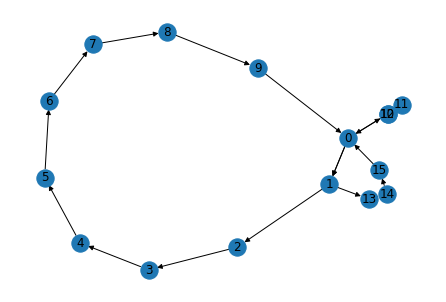

In [161]:
G = g1.get_nx_multigraph()
nx.draw_spectral(G,with_labels = True)

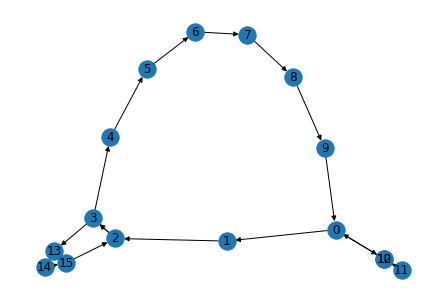

In [162]:
G = g2.get_nx_multigraph()
nx.draw_spectral(G,with_labels = True)

In [110]:
len(g1.edge_labels)

14

In [167]:
get_opt_aln(g1,g2,ag,subgraph)

[10, 11, 12, 0, 0, 10001, 10000, 0, 1, 1, 13, 14, 15, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0]
[10, 11, 12, 0, 1, 10001, 10000, 1, 2, 3, 13, 14, 15, 2, 2, 2, 3, 4, 5, 6, 7, 8, 9, 0]
4
ATCGTTCAGGACGTAGGCT
ATCGGATTCAACGTAGGCT


# Old stuff

In [ ]:

graph_files = [data_dir + f for f in os.listdir(data_dir) if "4.gfa" in f]

seg_len = 15
mut_rate = 0
num_copies = 3
nucs = []

length1 = int(normal(seg_len, 2))
length2 = int(normal(seg_len, 2))
# mut_rate = poisson(mut_rate)
# num_copies1 = poisson(num_copies)
num_copies1 = 2

i = 0
out_dict = defaultdict(list)

# for file1 in graph_files[1:5]:
j = 0
#     for file2 in graph_files[1:5]: 
file1 = graph_files[0]
file2 = graph_files[0]
prefix1 = file1.split("/")[-1].split(".")[0] 
prefix2 = file2.split("/")[-1].split(".")[0]

graph1 = Graph(fname = file1)
graph2 = Graph(fname = file2)

ed, s1, s2 = get_str_dist(graph1, graph2)

s1_seed1, loc = select_seed(s1, length1,5)
s1_seed2, loc = select_seed(s1, length1,5, loc)
s2_seed1, loc = select_seed(s2, length2,5)
s2_seed2, loc = select_seed(s2, length2,5, loc)

s1_seed1 = "BBBDDDBBB"

locs = [[2, 15], [9, 30]]

str_list = [s1,s2]
for i,s in enumerate(str_list):
    inserted_locs =set([0])
    inserted_locs2 = []
    new_seed = []
    for seed in [s1_seed1]:
        #, s1_seed2, s2_seed1, s2_seed2]:
        for _ in range(num_copies1):
            new_s = insert_mutation(seed, mut_rate)
#             loc = random.choice(100)
# #                 print(loc, inserted_locs[i])
#             while loc in inserted_locs:
#                 loc = int(random.choice(100))
#             for l in range(loc, loc+len(new_s)):
#                 inserted_locs.add(l)
#             inserted_locs2.append(loc)
            new_seed.append(new_s)

    total_increased = 0
    seed_loc = sorted([(i,j) for i,j in zip(new_seed, locs[i])], key=lambda x: x[1])
    for seed, loc in seed_loc:
        print(seed, loc)
        new_loc = loc + total_increased
        str_list[i] = str_list[i][:new_loc] + seed + str_list[i][new_loc:]
        total_increased += len(seed)
    print(seed_loc)
s11 = str_list[0][:50]
s22 = str_list[1][:50]
print(s11)
print(s22)
print(ed, Levenshtein.distance(s11, s22), len(s11), len(s22))

g1 = DeBruijnGraph(seqids = [(1,1)], seqs=[s11], k=4)
g2 = DeBruijnGraph(seqids = [(1,1)], seqs=[s22], k=4)

out_dict["s1"].append(s11)
out_dict["s2"].append(s22)

g1.to_gfa_multi(data_dir+prefix1 + "_mut_%i_%i" % (i,j)+"_1" + ".gfa")
g2.to_gfa_multi(data_dir+prefix2 + "_mut_%i_%i" % (i,j) +"_2" ".gfa")

start = time.time()

ag = Alignment_Graph(g1, g2)

time1 = time.time() - start
gp.setParam("OutputFlag", 0)
gp.setParam("LogToConsole", 0)

# gp.setParam("OutputFlag", 1)
# gp.setParam("LogToConsole", 1)


# start = time.time()

# model1 = GTED_ilp(ag, g1, g2, "test.lp", ilp)

# time2 = time.time() - start

# gted = model1.getObjective().getValue()

In [56]:
def construct_sol_graph(model):
    # get all x variables
    xs = dict()
    for v in model.getVars():
        if v.x > 0:
            if "x" in v.VarName:
                idx = int(v.VarName.lstrip("x[").rstrip("]"))
                xs[idx] = v.x
    
    subgraph = nx.MultiDiGraph()
    for idx in xs:
        n1,n2,c,w,e_type = ag.idx_to_edge[idx]
        for _ in range(int(xs[idx])):
#             if n1 == n2:
#                 print(n1, n2)
            subgraph.add_edge(n1,n2)
            
    subgraph.add_edge(ag.nodes[1], ag.nodes[0])
    
    return subgraph, xs     

In [55]:
# find the set of edges with u in C and v not in C
def update_scc_constr(model):

    subgraph, xs = construct_sol_graph(model)
#     get_opt_aln(subgraph)

    sccs = []
    for s in nx.strongly_connected_components(subgraph):
        if ag.nodes[1] not in s and ag.nodes[0] not in s:
#             print(s)
            sccs.append(s)
            
    if sccs == []:
        return model, -1
    
    for scc in sccs:
        scc_out = []
        scc_in = []
        
        scc_edges = []
        total_weight = 0
        for e in ag.idx_to_edge:
            n1, n2, c, w, e_type = ag.idx_to_edge[e]
            if n1 in scc and n2 not in scc:
                scc_out.append(e)
            elif n2 in scc and n1 not in scc:
                scc_in.append(e)
            if n1 in scc and n2 in scc:
                scc_edges.append(e)
        for e in xs:
            n1, n2, c, w, e_type = ag.idx_to_edge[e]
            if n1 in scc and n2 in scc:
#                 scc_edges.append(e)
                total_weight += xs[e]
#                 print(n1, n2, xs[e])
        total_weight = int(total_weight)
#         print("totalweight", total_weight)
        x = [v for v in model.getVars() if "x" in v.VarName]
        y = model.addVar(vtype=GRB.BINARY)
        
#         total_weight = len(scc)
    
        model.addConstr(sum(x[e] for e in scc_edges) >= total_weight - total_weight *(1-y))
        model.addConstr(sum(x[e] for e in scc_edges) - total_weight + 1 - total_weight * y <= 0)
        model.addConstr(sum([x[e] for e in scc_out]) >= y)
        model.addConstr(sum([x[e] for e in scc_in]) >= y)
    
#         print(len(sccs),total_weight, scc,scc_edges)
#         print("scc_out=",scc_out)
#         print("scc_in=",scc_in)
        model.update()
        
#         print(y)
        
    return model, subgraph

In [ ]:
def aln_edge_to_graph_edge(ag, g1, g2, e_idx):
    """
    Project edge idx in alignment edge to two input graphs
    
    Return:
        e1, e2
        None if no projection (due to horizontal or vertical edges)
    """
    
    n1, n2, c, w, e_type = ag.idx_to_edge[e_idx]
    u1,u2 = ag.idx_to_node[n1]
    v1,v2 = ag.idx_to_node[n2]
    
    # skip source/sink edges
    if e_type == "ss":
        return None, None
    
    # horizontal -- only to g1
    if e_type == "h":
        return (u1,v1),None
    
    # vertical -- only to g2
    if e_type == "v":
        return None, (u2, v2)

    else:
        return (u1,v1), (u2,v2)

In [ ]:
'''
This is Yutong trying to improve things but failing.
For each isolated SCC,
(1) find projection to G1 and G2
(2) find alignment graph between scc1=proj(G1, scc) and scc2=proj(G2, scc), which is a subgraph of the alignment graph
(3) Add constraints: 
    if sum(e in aln_sub) >= 1, then sum(e out of aln_sub) >= 1

    Linearized constraints:
    sum(e) <= 0 and sum(e_out) >= 1
    
    ==>
        sum(e) >= -M(1-y)
        sum(e) - My <= 0
        sum(e_out) >= y
'''
def update_scc_constr2(model):

    subgraph, xs = construct_sol_graph(model)
    get_opt_aln(subgraph)

    sccs = []
    for s in nx.strongly_connected_components(subgraph):
        if ag.nodes[1] not in s and ag.nodes[0] not in s:
#             print(s)
            sccs.append(s)
            
    if sccs == []:
        return model, -1
    
    print(sccs)
    
    for scc in sccs:
        g1_sub = set()
        g2_sub = set()
        aln_sub_edges = []
        aln_sub_out_edges = []
        for e in xs:
            n1, n2, c, w, e_type = ag.idx_to_edge[e]
            if n1 in scc and n2 in scc:
                u1,u2 = ag.idx_to_node[n1]
                v1,v2 = ag.idx_to_node[n2]
                g1_sub.add(u1)
                g1_sub.add(v1)
                g2_sub.add(u2)
                g2_sub.add(v2)
        
        for e in ag.idx_to_edge:
            n1, n2, c, w, e_type = ag.idx_to_edge[e]
            if n1 == ag.nodes[0] or n1 == ag.nodes[1] or n2 == ag.nodes[0] or n2 == ag.nodes[1]:
                continue
            u1,u2 = ag.idx_to_node[n1]
            v1,v2 = ag.idx_to_node[n2]
            if u1 in g1_sub and v1 in g1_sub and u2 in g2_sub and v2 in g2_sub:
                aln_sub_edges.append(e)
                
            if u1 in g1_sub and u2 in g2_sub and (v1 not in g1_sub or v2 not in g2_sub):
                aln_sub_out_edges.append(e)
                
        x = [v for v in model.getVars() if "x" in v.VarName]
        y = model.addVar(vtype=GRB.BINARY)
        
        model.addConstr(sum([x[e] for e in aln_sub_edges]) >= -len(ag.idx_to_edge) * (1-y))
        model.addConstr(sum([x[e] for e in aln_sub_edges]) - len(ag.idx_to_edge) * y <= 0)
        model.addConstr(sum([x[e] for e in aln_sub_out_edges]) >= y)
        model.update()
        
        print(g1_sub, g2_sub, aln_sub_edges,aln_sub_out_edges)
    return model, subgraph

In [65]:
def get_opt_aln(subgraph):
    for nodes in nx.strongly_connected_components(subgraph):
        sub = nx.induced_subgraph(subgraph, nodes)
        p1 = []
        p2 = []
        for edge in nx.eulerian_circuit(sub):
            if ag.idx_to_node[edge[1]] != 0 and ag.idx_to_node[edge[1]] != 1:
                p1.append(ag.idx_to_node[edge[1]][0])
                p2.append(ag.idx_to_node[edge[1]][1])    

        s1 = ""
        for i in range(len(p1)-1):
            e1 = (p1[i], p1[i+1])
            if e1 not in g1.edge_labels:
                s1 += "-"
            else:
                s1 += (g1.edge_labels[e1])
        s2 = ""
        for i in range(len(p2)-1):
            e2 = (p2[i], p2[i+1])
            if e2 not in g2.edge_labels:
                s2 += "-"
            else:
                s2 += g2.edge_labels[e2]
                
        if s1 == "" and s2 =="":
            return

        print(Levenshtein.distance(s1, s2))
        print(s1)
        print(s2)
        print(p1, p2)

In [ ]:

start = time.time()        
model = CCTED_ilp(ag, g1, g2, "test.lp", ilp)
time3 = time.time() - start

ccted = model.getObjective().getValue()
print("ILP result:", ccted)

model2 = GTED_ilp(ag, g1, g2, "test.lp", ilp)
gted = model2.getObjective().getValue()

print("GTED ilp:",gted)

In [ ]:
all_sccs = set()

In [ ]:
import gurobipy as gp
gp.setParam("OutputFlag", 0)
gp.setParam("LogToConsole", 0)


while True:

    subgraph, xs = construct_sol_graph(model)
    model, subgraph = update_scc_constr(model)

    if subgraph == -1:
        break

    for s in nx.strongly_connected_components(subgraph):
        if ag.nodes[1] not in s and ag.nodes[0] not in s:
#             scc_edges = []
#             for e in xs:
#                 n1, n2, c, w, e_type = ag.idx_to_edge[e]
#                 if n1 in s and n2 in s:
#                     scc_edges.append(e)
    #         print(s)
    #             break
            if tuple(sorted(tuple(s))) in all_sccs:
                print(tuple(sorted(tuple(s))))
            all_sccs.add(tuple(sorted(tuple(s))))
        get_opt_aln(subgraph)

    model.reset()
    model.optimize()
    if model.status != GRB.OPTIMAL:
        print(model.status)
        break
    print("subopt:",model.getObjective().getValue())
    
print("Optimal:", model.getObjective().getValue())

In [ ]:
for n in ag.incoming:
    ss = set()
    for e in ag.incoming[n]:
        ss.add(ag.idx_to_edge[e][:-1])
    if len(ss) != len(ag.incoming[n]):
        print(ss)

In [ ]:
[704, 705, 769, 1091, 1100, 5357, 5405, 5534, 5537, 5666, 5669, 5798, 5801]
[704, 708, 898, 1091, 1100, 5357, 5405, 5534, 5537, 5666, 5669, 5798, 5801]

In [ ]:
scc_edges = [704, 705, 769, 1091, 1100, 5357, 5405, 5534, 5537, 5666, 5669, 5798, 5801]
scc_out= [703, 706, 707, 709, 710, 768, 831, 832, 833, 834, 835, 836, 837, 838, 839, 897, 899, 960, 961, 962, 963, 964, 965, 966, 967, 968, 1026, 1028, 1089, 1092, 1093, 1094, 1095, 1096, 1097, 1099, 5355, 5404, 5532, 5536, 5664, 5668, 5796, 5800]
scc_in= [572, 573, 576, 579, 638, 639, 641, 644, 700, 701, 711, 766, 772, 773, 829, 895, 901, 958, 1024, 1030, 1087, 1146, 1156, 1159, 4571, 4572, 4575, 4578, 4637, 4638, 4640, 4643, 5347, 5406, 5485, 5538, 5662, 5670, 5732, 5733, 5736, 5739, 5794, 5804]


sum([xs[e] for e in scc_edges if e in xs])
[(ag.idx_to_edge[e]) for e in scc_edges if e not in xs]

In [ ]:
model.addConstr(sum(x[e] for e in scc_edges) >= total_weight - total_weight *(1-y))
model.addConstr(sum(x[e] for e in scc_edges) - total_weight + 1 - total_weight * y <= 0)
model.addConstr(sum([x[e] for e in scc_out]) >= y)
model.addConstr(sum([x[e] for e in scc_in]) >= y)

In [ ]:
model.getVarByName("C5816")

In [ ]:
scc_edges = [704, 898, 1100, 5405, 5535, 5537, 5666, 5669, 5798, 5801]

In [ ]:
sum([xs[e] for e in scc_edges if e in xs])

In [ ]:
for b in 

In [ ]:
[e for e in scc_out if e in xs]

In [ ]:
[e for e in scc_in if e in xs]

In [ ]:
ag.idx_to_edge[5535]

In [ ]:
ag.idx_to_edge[898]

In [ ]:
(0,78) in subgraph.edges

In [ ]:
a = [672, 673, 674, 675, 678, 679, 680, 702, 703, 704, 705, 706, 707, 708, 711, 712, 713, 714, 715, 716, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749, 750, 753, 754, 755, 759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 802, 808, 832, 835, 841, 844, 853, 856, 859, 862, 865, 868, 871, 874, 877, 883, 889, 892, 895, 898, 901, 930, 931, 932, 933, 936, 937, 938, 960, 961, 962, 963, 964, 965, 966, 969, 970, 971, 972, 973, 974, 981, 982, 983, 984, 985, 986, 987, 988, 989, 990, 991, 992, 993, 994, 995, 996, 997, 998, 999, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1011, 1012, 1013, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1059, 1060, 1061, 1062, 1065, 1066, 1067, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1098, 1099, 1100, 1101, 1102, 1103, 1110, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1120, 1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 1129, 1130, 1131, 1132, 1133, 1134, 1135, 1136, 1137, 1140, 1141, 1142, 1146, 1147, 1148, 1149, 1150, 1151, 1152, 1153, 1154, 1155, 1156, 1157, 1158, 1159, 1160, 1317, 1318, 1319, 1320, 1323, 1324, 1325, 1347, 1348, 1349, 1350, 1351, 1352, 1353, 1356, 1357, 1358, 1359, 1360, 1361, 1368, 1369, 1370, 1371, 1372, 1373, 1374, 1375, 1376, 1377, 1378, 1379, 1380, 1381, 1382, 1383, 1384, 1385, 1386, 1387, 1388, 1389, 1390, 1391, 1392, 1393, 1394, 1395, 1398, 1399, 1400, 1404, 1405, 1406, 1407, 1408, 1409, 1410, 1411, 1412, 1413, 1414, 1415, 1416, 1417, 1418, 1446, 1447, 1448, 1449, 1452, 1453, 1454, 1476, 1477, 1478, 1479, 1480, 1481, 1482, 1485, 1486, 1487, 1488, 1489, 1490, 1497, 1498, 1499, 1500, 1501, 1502, 1503, 1504, 1505, 1506, 1507, 1508, 1509, 1510, 1511, 1512, 1513, 1514, 1515, 1516, 1517, 1518, 1519, 1520, 1521, 1522, 1523, 1524, 1527, 1528, 1529, 1533, 1534, 1535, 1536, 1537, 1538, 1539, 1540, 1541, 1542, 1543, 1544, 1545, 1546, 1547, 1575, 1576, 1577, 1578, 1581, 1582, 1583, 1605, 1606, 1607, 1608, 1609, 1610, 1611, 1614, 1615, 1616, 1617, 1618, 1619, 1626, 1627, 1628, 1629, 1630, 1631, 1632, 1633, 1634, 1635, 1636, 1637, 1638, 1639, 1640, 1641, 1642, 1643, 1644, 1645, 1646, 1647, 1648, 1649, 1650, 1651, 1652, 1653, 1656, 1657, 1658, 1662, 1663, 1664, 1665, 1666, 1667, 1668, 1669, 1670, 1671, 1672, 1673, 1674, 1675, 1676, 1705, 1711, 1735, 1738, 1744, 1747, 1756, 1759, 1762, 1765, 1768, 1771, 1774, 1777, 1780, 1786, 1792, 1795, 1798, 1801, 1804, 1833, 1834, 1835, 1836, 1839, 1840, 1841, 1863, 1864, 1865, 1866, 1867, 1868, 1869, 1872, 1873, 1874, 1875, 1876, 1877, 1884, 1885, 1886, 1887, 1888, 1889, 1890, 1891, 1892, 1893, 1894, 1895, 1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909, 1910, 1911, 1914, 1915, 1916, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 3381, 3382, 3383, 3384, 3387, 3388, 3389, 3411, 3412, 3413, 3414, 3415, 3416, 3417, 3420, 3421, 3422, 3423, 3424, 3425, 3432, 3433, 3434, 3435, 3436, 3437, 3438, 3439, 3440, 3441, 3442, 3443, 3444, 3445, 3446, 3447, 3448, 3449, 3450, 3451, 3452, 3453, 3454, 3455, 3456, 3457, 3458, 3459, 3462, 3463, 3464, 3468, 3469, 3470, 3471, 3472, 3473, 3474, 3475, 3476, 3477, 3478, 3479, 3480, 3481, 3482, 3511, 3517, 3541, 3544, 3550, 3553, 3562, 3565, 3568, 3571, 3574, 3577, 3580, 3583, 3586, 3592, 3598, 3601, 3604, 3607, 3610, 3639, 3640, 3641, 3642, 3645, 3646, 3647, 3669, 3670, 3671, 3672, 3673, 3674, 3675, 3678, 3679, 3680, 3681, 3682, 3683, 3690, 3691, 3692, 3693, 3694, 3695, 3696, 3697, 3698, 3699, 3700, 3701, 3702, 3703, 3704, 3705, 3706, 3707, 3708, 3709, 3710, 3711, 3712, 3713, 3714, 3715, 3716, 3717, 3720, 3721, 3722, 3726, 3727, 3728, 3729, 3730, 3731, 3732, 3733, 3734, 3735, 3736, 3737, 3738, 3739, 3740, 3768, 3769, 3770, 3771, 3774, 3775, 3776, 3798, 3799, 3800, 3801, 3802, 3803, 3804, 3807, 3808, 3809, 3810, 3811, 3812, 3819, 3820, 3821, 3822, 3823, 3824, 3825, 3826, 3827, 3828, 3829, 3830, 3831, 3832, 3833, 3834, 3835, 3836, 3837, 3838, 3839, 3840, 3841, 3842, 3843, 3844, 3845, 3846, 3849, 3850, 3851, 3855, 3856, 3857, 3858, 3859, 3860, 3861, 3862, 3863, 3864, 3865, 3866, 3867, 3868, 3869, 3897, 3898, 3899, 3900, 3903, 3904, 3905, 3927, 3928, 3929, 3930, 3931, 3932, 3933, 3936, 3937, 3938, 3939, 3940, 3941, 3948, 3949, 3950, 3951, 3952, 3953, 3954, 3955, 3956, 3957, 3958, 3959, 3960, 3961, 3962, 3963, 3964, 3965, 3966, 3967, 3968, 3969, 3970, 3971, 3972, 3973, 3974, 3975, 3978, 3979, 3980, 3984, 3985, 3986, 3987, 3988, 3989, 3990, 3991, 3992, 3993, 3994, 3995, 3996, 3997, 3998, 4026, 4027, 4028, 4029, 4032, 4033, 4034, 4056, 4057, 4058, 4059, 4060, 4061, 4062, 4065, 4066, 4067, 4068, 4069, 4070, 4077, 4078, 4079, 4080, 4081, 4082, 4083, 4084, 4085, 4086, 4087, 4088, 4089, 4090, 4091, 4092, 4093, 4094, 4095, 4096, 4097, 4098, 4099, 4100, 4101, 4102, 4103, 4104, 4107, 4108, 4109, 4113, 4114, 4115, 4116, 4117, 4118, 4119, 4120, 4121, 4122, 4123, 4124, 4125, 4126, 4127, 4155, 4156, 4157, 4158, 4161, 4162, 4163, 4185, 4186, 4187, 4188, 4189, 4190, 4191, 4194, 4195, 4196, 4197, 4198, 4199, 4206, 4207, 4208, 4209, 4210, 4211, 4212, 4213, 4214, 4215, 4216, 4217, 4218, 4219, 4220, 4221, 4222, 4223, 4224, 4225, 4226, 4227, 4228, 4229, 4230, 4231, 4232, 4233, 4236, 4237, 4238, 4242, 4243, 4244, 4245, 4246, 4247, 4248, 4249, 4250, 4251, 4252, 4253, 4254, 4255, 4256, 4284, 4285, 4286, 4287, 4290, 4291, 4292, 4314, 4315, 4316, 4317, 4318, 4319, 4320, 4323, 4324, 4325, 4326, 4327, 4328, 4335, 4336, 4337, 4338, 4339, 4340, 4341, 4342, 4343, 4344, 4345, 4346, 4347, 4348, 4349, 4350, 4351, 4352, 4353, 4354, 4355, 4356, 4357, 4358, 4359, 4360, 4361, 4362, 4365, 4366, 4367, 4371, 4372, 4373, 4374, 4375, 4376, 4377, 4378, 4379, 4380, 4381, 4382, 4383, 4384, 4385, 4413, 4414, 4415, 4416, 4419, 4420, 4421, 4443, 4444, 4445, 4446, 4447, 4448, 4449, 4452, 4453, 4454, 4455, 4456, 4457, 4464, 4465, 4466, 4467, 4468, 4469, 4470, 4471, 4472, 4473, 4474, 4475, 4476, 4477, 4478, 4479, 4480, 4481, 4482, 4483, 4484, 4485, 4486, 4487, 4488, 4489, 4490, 4491, 4494, 4495, 4496, 4500, 4501, 4502, 4503, 4504, 4505, 4506, 4507, 4508, 4509, 4510, 4511, 4512, 4513, 4514, 4542, 4543, 4544, 4545, 4548, 4549, 4550, 4572, 4573, 4574, 4575, 4576, 4577, 4578, 4581, 4582, 4583, 4584, 4585, 4586, 4593, 4594, 4595, 4596, 4597, 4598, 4599, 4600, 4601, 4602, 4603, 4604, 4605, 4606, 4607, 4608, 4609, 4610, 4611, 4612, 4613, 4614, 4615, 4616, 4617, 4618, 4619, 4620, 4623, 4624, 4625, 4629, 4630, 4631, 4632, 4633, 4634, 4635, 4636, 4637, 4638, 4639, 4640, 4641, 4642, 4643, 5316, 5317, 5318, 5319, 5322, 5323, 5324, 5346, 5347, 5348, 5349, 5350, 5351, 5352, 5355, 5356, 5357, 5358, 5359, 5360, 5367, 5368, 5369, 5370, 5371, 5372, 5373, 5374, 5375, 5376, 5377, 5378, 5379, 5380, 5381, 5382, 5383, 5384, 5385, 5386, 5387, 5388, 5389, 5390, 5391, 5392, 5393, 5394, 5397, 5398, 5399, 5403, 5404, 5405, 5406, 5407, 5408, 5409, 5410, 5411, 5412, 5413, 5414, 5415, 5416, 5417, 5445, 5446, 5447, 5448, 5451, 5452, 5453, 5475, 5476, 5477, 5478, 5479, 5480, 5481, 5484, 5485, 5486, 5487, 5488, 5489, 5496, 5497, 5498, 5499, 5500, 5501, 5502, 5503, 5504, 5505, 5506, 5507, 5508, 5509, 5510, 5511, 5512, 5513, 5514, 5515, 5516, 5517, 5518, 5519, 5520, 5521, 5522, 5523, 5526, 5527, 5528, 5532, 5533, 5534, 5535, 5536, 5537, 5538, 5539, 5540, 5541, 5542, 5543, 5544, 5545, 5546, 5574, 5575, 5576, 5577, 5580, 5581, 5582, 5604, 5605, 5606, 5607, 5608, 5609, 5610, 5613, 5614, 5615, 5616, 5617, 5618, 5625, 5626, 5627, 5628, 5629, 5630, 5631, 5632, 5633, 5634, 5635, 5636, 5637, 5638, 5639, 5640, 5641, 5642, 5643, 5644, 5645, 5646, 5647, 5648, 5649, 5650, 5651, 5652, 5655, 5656, 5657, 5661, 5662, 5663, 5664, 5665, 5666, 5667, 5668, 5669, 5670, 5671, 5672, 5673, 5674, 5675, 5703, 5704, 5705, 5706, 5709, 5710, 5711, 5733, 5734, 5735, 5736, 5737, 5738, 5739, 5742, 5743, 5744, 5745, 5746, 5747, 5754, 5755, 5756, 5757, 5758, 5759, 5760, 5761, 5762, 5763, 5764, 5765, 5766, 5767, 5768, 5769, 5770, 5771, 5772, 5773, 5774, 5775, 5776, 5777, 5778, 5779, 5780, 5781, 5784, 5785, 5786, 5790, 5791, 5792, 5793, 5794, 5795, 5796, 5797, 5798, 5799, 5800, 5801, 5802, 5803, 5804] 
b = [676, 677, 709, 710, 751, 752, 801, 803, 804, 805, 806, 807, 809, 831, 833, 834, 836, 837, 838, 839, 840, 842, 843, 845, 852, 854, 855, 857, 858, 860, 861, 863, 864, 866, 867, 869, 870, 872, 873, 875, 876, 878, 879, 880, 881, 882, 884, 888, 890, 891, 893, 894, 896, 897, 899, 900, 902, 934, 935, 967, 968, 1009, 1010, 1063, 1064, 1096, 1097, 1138, 1139, 1321, 1322, 1354, 1355, 1396, 1397, 1450, 1451, 1483, 1484, 1525, 1526, 1579, 1580, 1612, 1613, 1654, 1655, 1704, 1706, 1707, 1708, 1709, 1710, 1712, 1734, 1736, 1737, 1739, 1740, 1741, 1742, 1743, 1745, 1746, 1748, 1755, 1757, 1758, 1760, 1761, 1763, 1764, 1766, 1767, 1769, 1770, 1772, 1773, 1775, 1776, 1778, 1779, 1781, 1782, 1783, 1784, 1785, 1787, 1791, 1793, 1794, 1796, 1797, 1799, 1800, 1802, 1803, 1805, 1837, 1838, 1870, 1871, 1912, 1913, 3385, 3386, 3418, 3419, 3460, 3461, 3510, 3512, 3513, 3514, 3515, 3516, 3518, 3540, 3542, 3543, 3545, 3546, 3547, 3548, 3549, 3551, 3552, 3554, 3561, 3563, 3564, 3566, 3567, 3569, 3570, 3572, 3573, 3575, 3576, 3578, 3579, 3581, 3582, 3584, 3585, 3587, 3588, 3589, 3590, 3591, 3593, 3597, 3599, 3600, 3602, 3603, 3605, 3606, 3608, 3609, 3611, 3643, 3644, 3676, 3677, 3718, 3719, 3772, 3773, 3805, 3806, 3847, 3848, 3901, 3902, 3934, 3935, 3976, 3977, 4030, 4031, 4063, 4064, 4105, 4106, 4159, 4160, 4192, 4193, 4234, 4235, 4288, 4289, 4321, 4322, 4363, 4364, 4417, 4418, 4450, 4451, 4492, 4493, 4546, 4547, 4579, 4580, 4621, 4622, 5320, 5321, 5353, 5354, 5395, 5396, 5449, 5450, 5482, 5483, 5524, 5525, 5578, 5579, 5611, 5612, 5653, 5654, 5707, 5708, 5740, 5741, 5782, 5783]

In [ ]:
[e for e in b if e in xs]

In [ ]:
ag.idx_to_edge[1784]

In [ ]:
ag.idx_to_edge[3515]

In [ ]:
[nx.induced_subgraph(subgraph,s).edges for s in nx.strongly_connected_components(subgraph)]

#### sum([xs[e] for e in a if e in xs])

In [ ]:
model.status

In [ ]:
subgraph = construct_sol_graph(model)

In [ ]:
get_opt_aln(subgraph)

In [ ]:
g2.adj_list[16][16]

In [ ]:
ag.idx_to_node[169]

In [ ]:
ag.idx_to_edge[538]

In [ ]:
xx = []
for cons in model1.getConstrs():
    if cons.rhs == 15:
        c = model1.getRow(cons)
        ss = ""
        sumx = 0
        for i in range(c.size()):
            ss += str(c.getCoeff(i)) + c.getVar(i).VarName + " + "
            xidx = int(c.getVar(i).VarName.lstrip("x[").rstrip("]"))
            n1, n2, cost, w = ag.idx_to_edge[xidx]
            u1,u2 = ag.idx_to_node[n1]
            v1,v2 = ag.idx_to_node[n2]
            if u2 == v2 and u2 == 16:
                if xidx in xs2:
                    sumx += xs2[xidx]
                    print(i,u1,v1,u2,v2,xs2[xidx])
                    xx.append(xidx)
#         print(sumx)
#         print(ss)

In [ ]:
sumx

In [ ]:
xx

In [ ]:
xs2[34280]

## later

In [ ]:
g1 = Graph(fname=data_dir+"test_graph1.gfa")
g2 = Graph(fname=data_dir+"test_graph2.gfa")

start = time.time()
ag = Alignment_Graph(g1, g2)

time1 = time.time() - start
start = time.time()

model1 = GTED_ilp(ag, g1, g2, "test.lp", True)

time2 = time.time() - start

gted = model.getObjective().getValue()

start = time.time()        
model2 = CCTED_ilp(ag, g1, g2, "test.lp", True)
time3 = time.time() - start

ccted = model.getObjective().getValue()

In [ ]:
for d in model1.getVars():
    if "d" in d.VarName and d.x != 0:
        eid = int(d.VarName.lstrip("d[").rstrip("]"))
        print(ag.idx_to_edge[eid])
        print(d)
        
    if "x" in d.VarName and d.x != 0:
        eid = int(d.VarName.lstrip("x[").rstrip("]"))
        print(ag.idx_to_edge[eid])
        print(d)
        
    if "y" in d.VarName and d.x != 0:
        eid = int(d.VarName.lstrip("y[").rstrip("]"))
        print(ag.idx_to_edge[eid])
        print(d)

In [ ]:

for i in range(length):
    if random.choice(10) <= mut_rate:
        print(True)

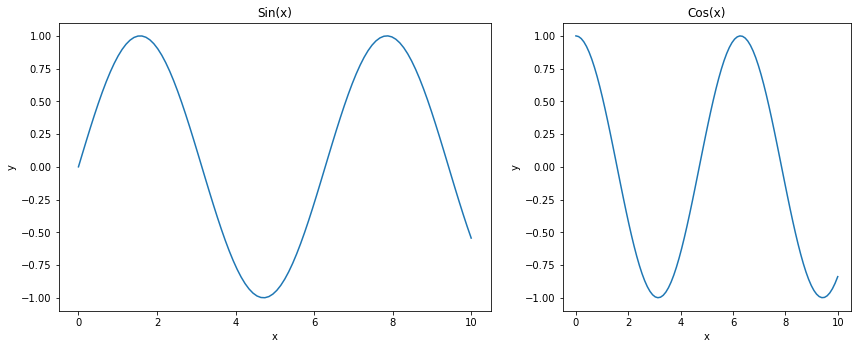

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Generate some sample data
x = np.linspace(0, 10, 100)
y1 = np.sin(x)
y2 = np.cos(x)

# Create the figure and subplots
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

# Create the first subplot
axs[0].plot(x, y1)
axs[0].set_title('Sin(x)')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')

# Create the second subplot
axs[1].plot(x, y2)
axs[1].set_title('Cos(x)')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')

# Adjust the layout to make the first subplot larger
axs[0].set_position([0.1, 0.1, 0.6, 0.8])
axs[1].set_position([0.8, 0.1, 0.4, 0.8])


# Show the plot
plt.show()